# Loss Function Effect on Different Distributions

For this exercise we are going to simulate different time series using the sinusoidal form for the deterministic term and using a different distributions in which the average and the median are very different for the noise term. Then, we fit a simple dense neural network with different loss functions in order to fit the model to the data and then recover the error distribution and analyze the mean and the median.

Before proceeding, we import the necessary modules and packages:

In [1]:
# Own Modules

from TimeSeries.classes import *
from TimeSeries.utils import *
from NeuralNetworks.classes import *
from ErrorModelling.classes import *
from ErrorModelling.utils import *

# Other modules

import numpy as np
from sklearn.preprocessing import StandardScaler
import keras

**No Stochastic Process**

We simulate the time series with no error term. In this case, the time series will be a function of the form:

$$f(t)=\sin(0.05t+1)$$

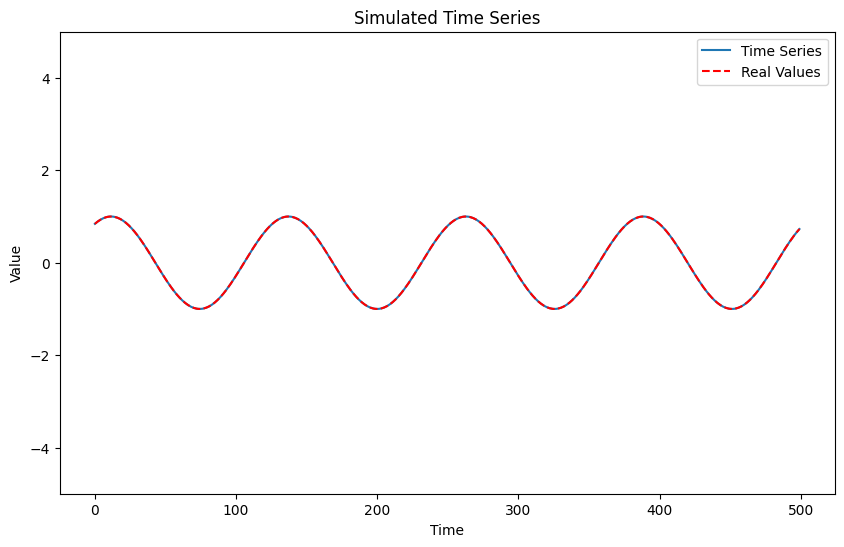

In [2]:
n = 500
loc = 0
scale = 0.1
params = {"A": 1, "B":0.05, "C":1}

simul = TimeSeriesSimulator(determ=sinForm,noise=None)
series = simul.simulate(det_params=params,n=500)
simul.plot_sim(scatter_plot=False)

theory = {
    "mean": "None",
    "std": "None",
    "median": "None",
}

Then, we fit a dense neural network to our data. The architecture of this neural network is the follwoing:

- 1 linear input layer with 10 units (sequence length; can be changed)
- 1 ReLU hidden layer with 128 units
- 1 linear output layer with 1 unit
- Batch size of 16
- 50 epochs for training

We use an ADAM optimizer and we try 3 different loss funcions: the L1, the L2 and the Huber losses.

In [3]:
scaler = StandardScaler()
series["Value"] = scaler.fit_transform(series[["Value"]])
seq_length = 10
data = series["Value"].values
series["Determ"] = series["Determ"].iloc[seq_length:].reset_index(drop=True)
x, y = create_sequences_from_ts(data, seq_length)

input_shape = (seq_length,)
x = x.reshape(x.shape[0], seq_length)

# Aprendizaje de la series

vanilla_generator = VanillaNNGenerator()
model = vanilla_generator.generate(input_shape=input_shape,
                                   units={"input": seq_length, "1": 128, "output": 1},
                                   activation={"input": None, "1": "relu", "output": None})

nn_handler = NeuralNetworkHandler(model=model)
loss_functions = {
    "L1": "mae",
    "L2": "mse",
    "Huber": keras.losses.Huber(delta=0.5)  # You can adjust delta as needed
}

results = {}
predictions_dict = {}

for loss_name, loss_fn in loss_functions.items():
    print(f"\nTraining with {loss_name} loss...\n")
    
    # Compile the model with the selected loss function
    nn_handler.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.01),
        loss=loss_fn,
        metrics=["mae","mse","mape"],
        n_batches=1
    )
    
    # Train the model
    nn_handler.train(
        train_x=x,
        train_y=y,
        batch_size=16,
        epochs=50,
        shuffle=True,
        callback=None,
        y_weights=None,
        x_weights=None,
        opt_hyp=False
    )
    
    # Evaluate the model
    loss = nn_handler.evaluate(
        train_x=x,
        train_y=y,
        batch_size=16,
        x_weights=None,
        callbacks=None
    )
    print(f"Evaluation results ({loss_name}): {loss}")
    results[loss_name] = loss

    # Predict with the trained model
    predictions = nn_handler.predict(test_x=x, batch_size=16, callbacks=None)
    predicted_values = np.array(predictions["pred"])

    # Inverse transform the predictions for plotting
    predicted_values = scaler.inverse_transform(predicted_values.reshape(-1, 1))
    predictions_dict[loss_name] = predicted_values

    # Inverse transform the ground truth
    y_test = scaler.inverse_transform(y.reshape(-1, 1))

# Display evaluation results
for loss_name, evaluation_result in results.items():
    print(f"{loss_name} Loss Evaluation: {evaluation_result}")


Training with L1 loss...

Epoch 1/50


c:\Users\Iker\Desktop\Algoritmos_Perrotes\ModellingError_TS\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4017 - mae: 0.4017 - mape: 108.1108 - mse: 0.3323
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0447 - mae: 0.0447 - mape: 12.7710 - mse: 0.0032
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1028 - mae: 0.1028 - mape: 21.9341 - mse: 0.0158
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0742 - mae: 0.0742 - mape: 18.1069 - mse: 0.0095
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0560 - mae: 0.0560 - mape: 15.4918 - mse: 0.0051
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0603 - mae: 0.0603 - mape: 22.1916 - mse: 0.0072
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0438 - mae: 0.0438 - mape: 10.5743 - mse: 0.0031
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0362 - mae: 0.0362 - mape: 6.0444 - mse: 0.0022
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0435 - mae: 0.0435 - mape: 7.9841 - mse: 0.0036   
Epoch 10/50
31/31 ━━━━━━━━━━

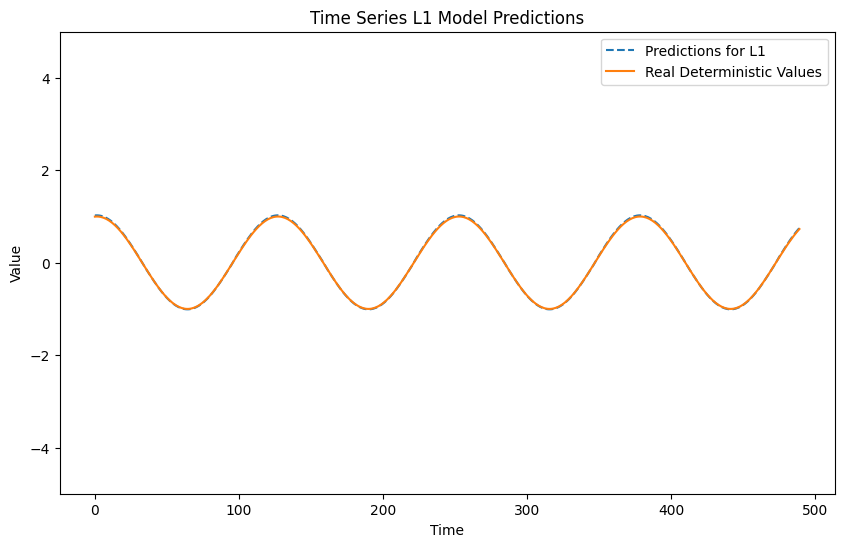

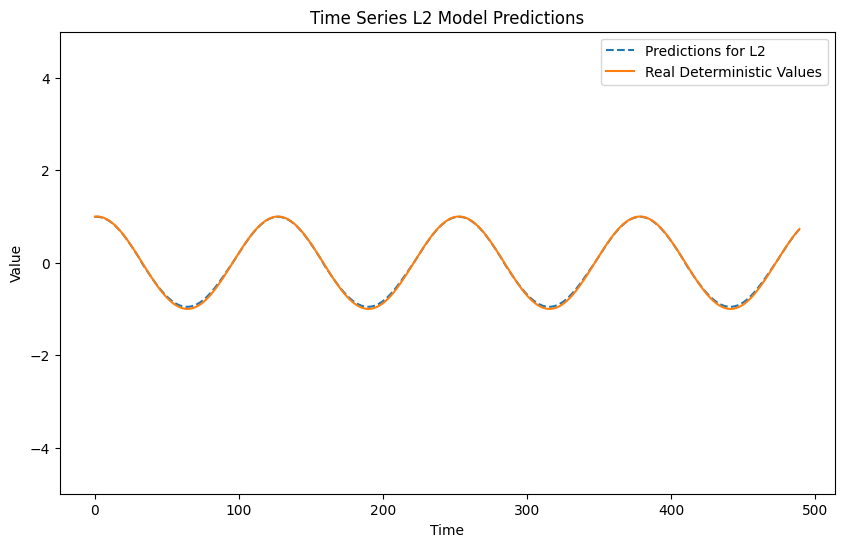

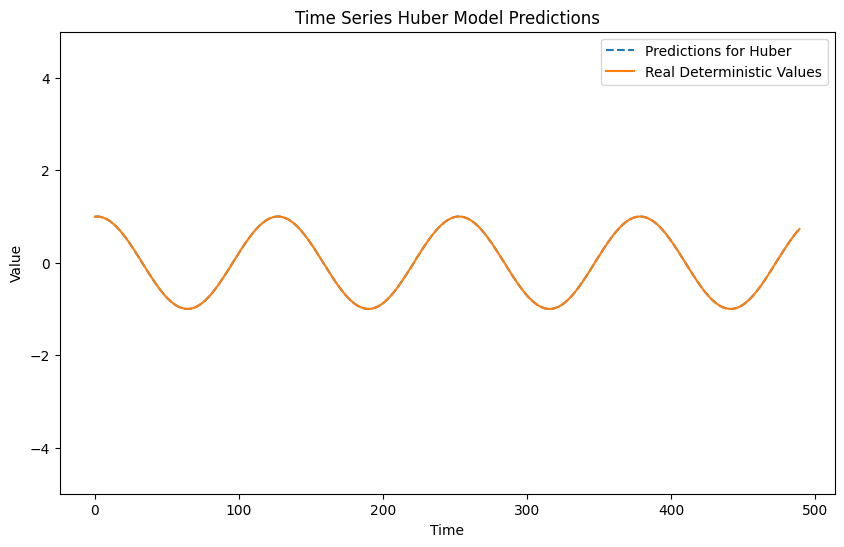

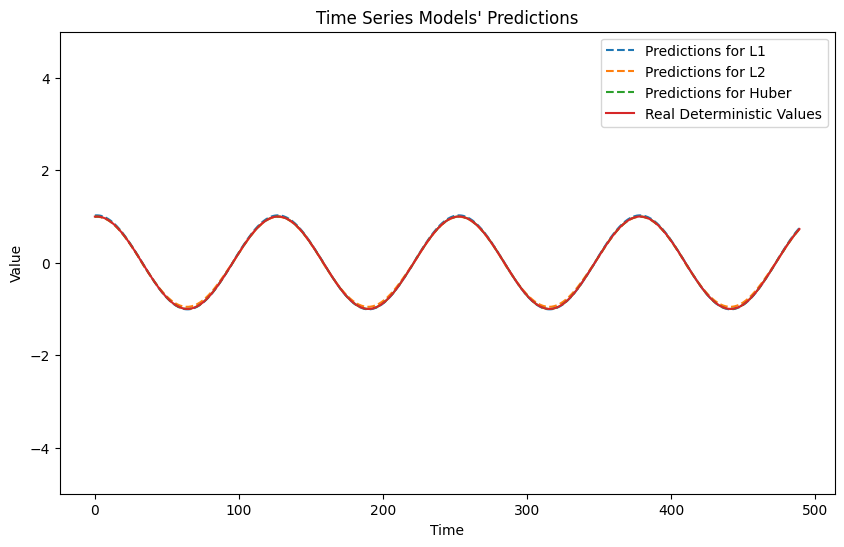

In [4]:
for k in predictions_dict.keys():

    plot_estimations(predictions=predictions_dict[k],series=series,model_name=k,use_total_series=False)

plot_multiple_estimations(pred_dict=predictions_dict,series=series,use_total_series=False)

Finally, we recover the distribution of errors through an histogram and a kernel density estimation:

Analyzing errors for L1 loss...

Mean: -0.005967948421143719 vs. Theoretical Mean: None
Median: 0.0004403149125667954 vs. Theoretical Median: None
Standard Dev.: 0.012589872227362341 vs. Theoretical Std. Dev.: None
Skew: -0.3051921019642595
Kurtosis: -1.5276178732687278
Max: 0.008921930755258378
Min: -0.025844579691114866




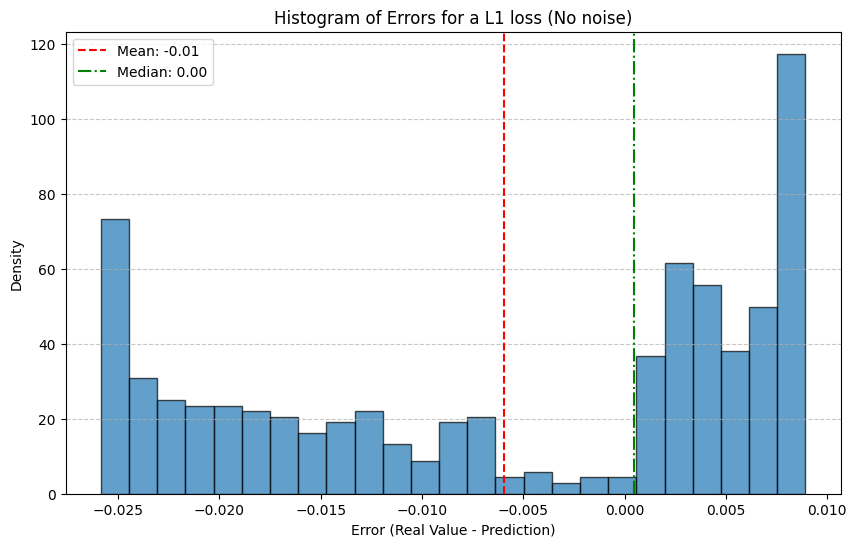

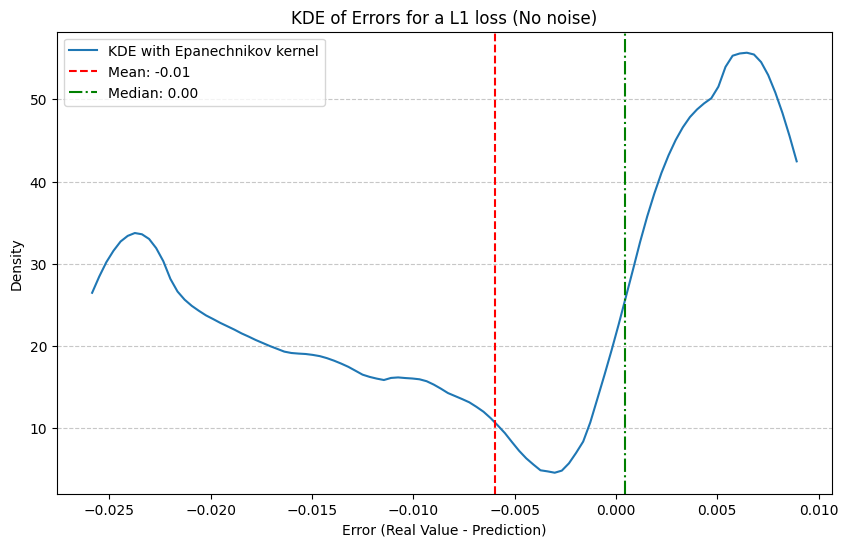

Analyzing errors for L2 loss...

Mean: -0.011329102474636988 vs. Theoretical Mean: None
Median: 0.0034349733413339967 vs. Theoretical Median: None
Standard Dev.: 0.020716985340199796 vs. Theoretical Std. Dev.: None
Skew: -0.6048918641370719
Kurtosis: -1.3352652974986934
Max: 0.015470587426454338
Min: -0.04696555364358235




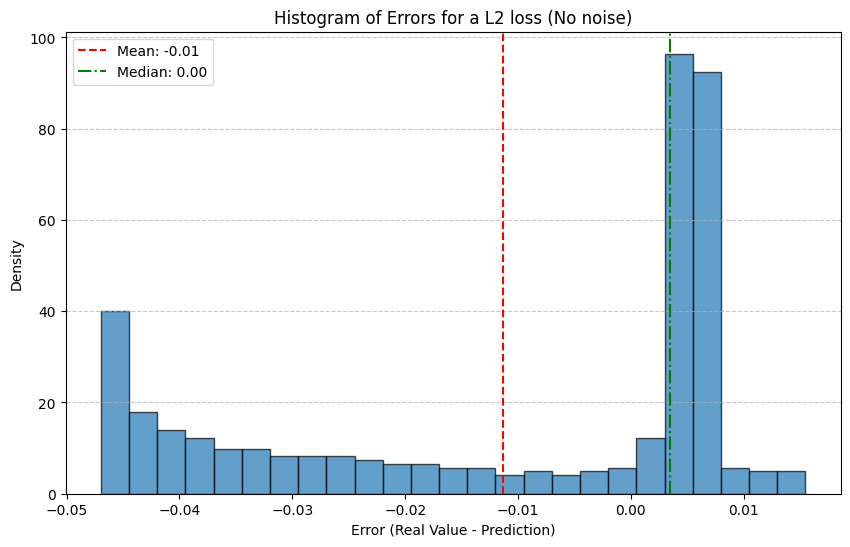

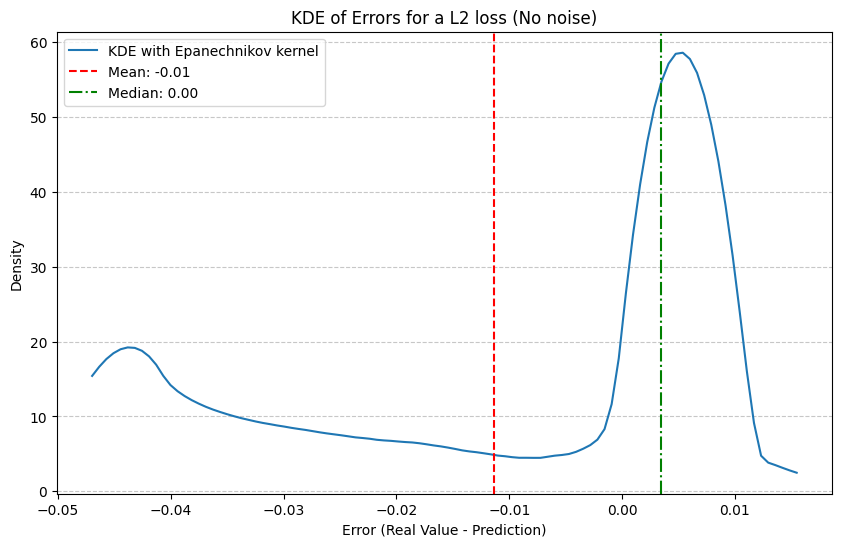

Analyzing errors for Huber loss...

Mean: 0.00024492142371183276 vs. Theoretical Mean: None
Median: 0.00025125695923494673 vs. Theoretical Median: None
Standard Dev.: 0.0007201516393014705 vs. Theoretical Std. Dev.: None
Skew: 1.0741333023729533
Kurtosis: 11.18856750252173
Max: 0.004601982391421691
Min: -0.004065281919509306




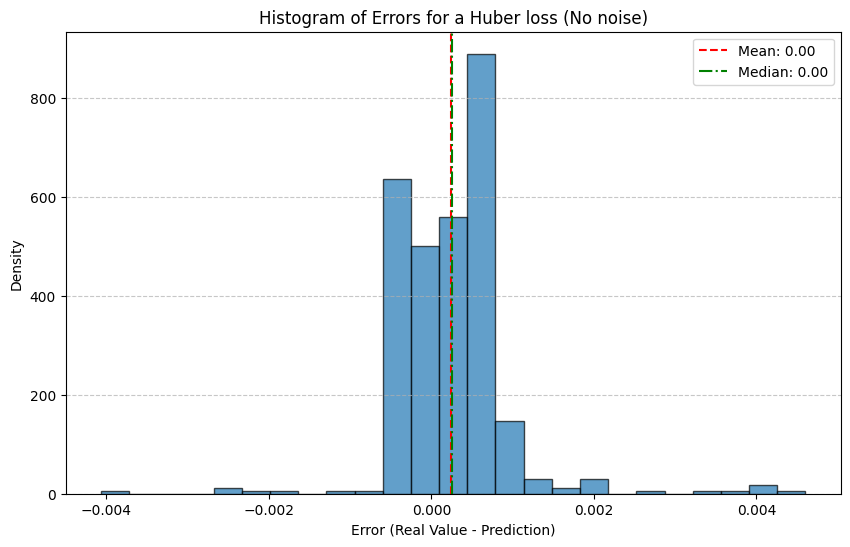

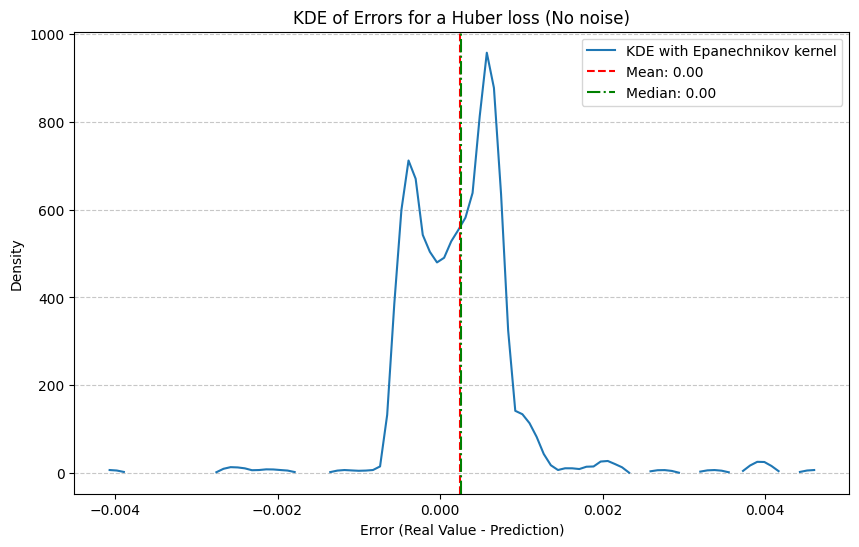

In [5]:
results = {}

for loss, predicted_values in predictions_dict.items():
    print(f"Analyzing errors for {loss} loss...\n")
    
    errors = y_test.flatten() - predicted_values.flatten()
    results[loss] = stats_results(errors,theory)

    plot_hist = RecoveryPlotHist(errors=errors,dist=None)
    plot_hist.get_plot(loss_name=loss)

    bw = 1.06 * np.std(errors) * len(errors)**(-1/5)
    plot_kernel = RecoveryPlotKernel(errors=errors,dist=None,kernel="epa",bw=bw)
    plot_kernel.get_plot(loss_name=loss)

**Gaussian Stochastic Process**

We simulate the time series with a Normally-distributed error term. In this case, the time series will be a function of the form:

$$f(t)=\sin(0.05t+1)+\varepsilon \quad \text{where} \quad \varepsilon \sim \mathcal{N}(0,1)$$

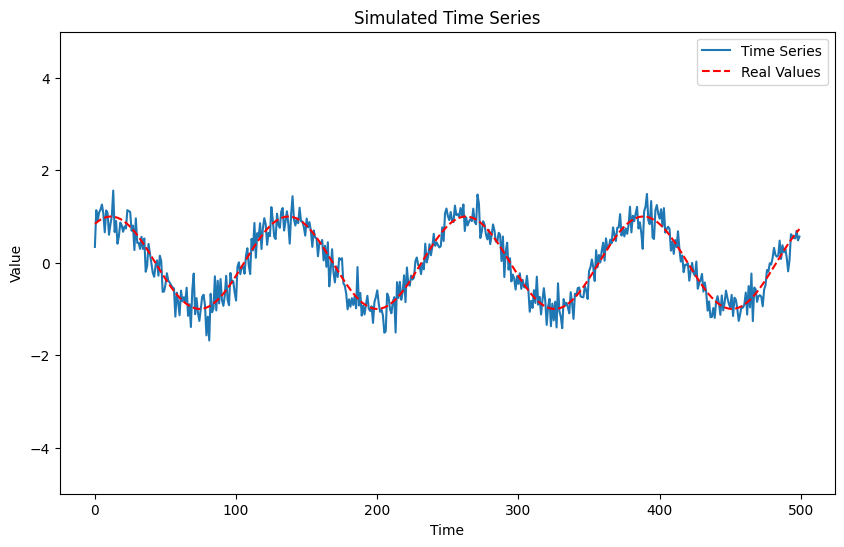

Theoretical Mean: 0
Theoretical Std. Dev.: 0.25
Theoretical Median: 0



In [6]:
n = 500
params = {"A": 1, "B":0.05, "C":1}
norm = NormalDist({"loc": 0, "scale":0.25})

simul = TimeSeriesSimulator(determ=sinForm,noise=norm)
series = simul.simulate(det_params=params,n=500)
simul.plot_sim(scatter_plot=False)

theory = norm.theory()

print(f"Theoretical Mean: {theory["mean"]}")
print(f"Theoretical Std. Dev.: {theory["std"]}")
print(f"Theoretical Median: {theory["median"]}\n")


Then, we fit a dense neural network to our data. The architecture of this neural network is the follwoing:

- 1 linear input layer with 10 units (sequence length; can be changed)
- 1 ReLU hidden layer with 128 units
- 1 linear output layer with 1 unit
- Batch size of 16
- 50 epochs for training

We use an ADAM optimizer and we try 3 different loss funcions: the L1, the L2 and the Huber losses.

In [7]:
scaler = StandardScaler()
series["Value"] = scaler.fit_transform(series[["Value"]])
seq_length = 10
data = series["Value"].values
series["Determ"] = series["Determ"].iloc[seq_length:].reset_index(drop=True)
x, y = create_sequences_from_ts(data, seq_length)

input_shape = (seq_length,)
x = x.reshape(x.shape[0], seq_length)

# Aprendizaje de la series

vanilla_generator = VanillaNNGenerator()
model = vanilla_generator.generate(input_shape=input_shape,
                                   units={"input": seq_length, "1": 128, "output": 1},
                                   activation={"input": None, "1": "relu", "output": None})

nn_handler = NeuralNetworkHandler(model=model)
loss_functions = {
    "L1": "mae",
    "L2": "mse",
    "Huber": keras.losses.Huber(delta=0.5)  # You can adjust delta as needed
}

results = {}
predictions_dict = {}

for loss_name, loss_fn in loss_functions.items():
    print(f"\nTraining with {loss_name} loss...\n")
    
    # Compile the model with the selected loss function
    nn_handler.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.01),
        loss=loss_fn,
        metrics=["mae","mse","mape"],
        n_batches=1
    )
    
    # Train the model
    nn_handler.train(
        train_x=x,
        train_y=y,
        batch_size=16,
        epochs=50,
        shuffle=True,
        callback=None,
        y_weights=None,
        x_weights=None,
        opt_hyp=False
    )
    
    # Evaluate the model
    loss = nn_handler.evaluate(
        train_x=x,
        train_y=y,
        batch_size=16,
        x_weights=None,
        callbacks=None
    )
    print(f"Evaluation results ({loss_name}): {loss}")
    results[loss_name] = loss

    # Predict with the trained model
    predictions = nn_handler.predict(test_x=x, batch_size=16, callbacks=None)
    predicted_values = np.array(predictions["pred"])

    # Inverse transform the predictions for plotting
    predicted_values = scaler.inverse_transform(predicted_values.reshape(-1, 1))
    predictions_dict[loss_name] = predicted_values

    # Inverse transform the ground truth
    y_test = scaler.inverse_transform(y.reshape(-1, 1))

# Display evaluation results
for loss_name, evaluation_result in results.items():
    print(f"{loss_name} Loss Evaluation: {evaluation_result}")


Training with L1 loss...

Epoch 1/50


c:\Users\Iker\Desktop\Algoritmos_Perrotes\ModellingError_TS\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4330 - mae: 0.4330 - mape: 108.4335 - mse: 0.2905
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3218 - mae: 0.3218 - mape: 92.7575 - mse: 0.1702
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3068 - mae: 0.3068 - mape: 91.0304 - mse: 0.1470
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3004 - mae: 0.3004 - mape: 79.7284 - mse: 0.1429
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2869 - mae: 0.2869 - mape: 85.7976 - mse: 0.1322
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2956 - mae: 0.2956 - mape: 98.9700 - mse: 0.1412 
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3215 - mae: 0.3215 - mape: 88.7731 - mse: 0.1669
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3046 - mae: 0.3046 - mape: 102.9164 - mse: 0.1461
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3067 - mae: 0.3067 - mape: 75.6545 - mse: 0.1478
Epoch 10/50
31/31 ━━━━━━━━━

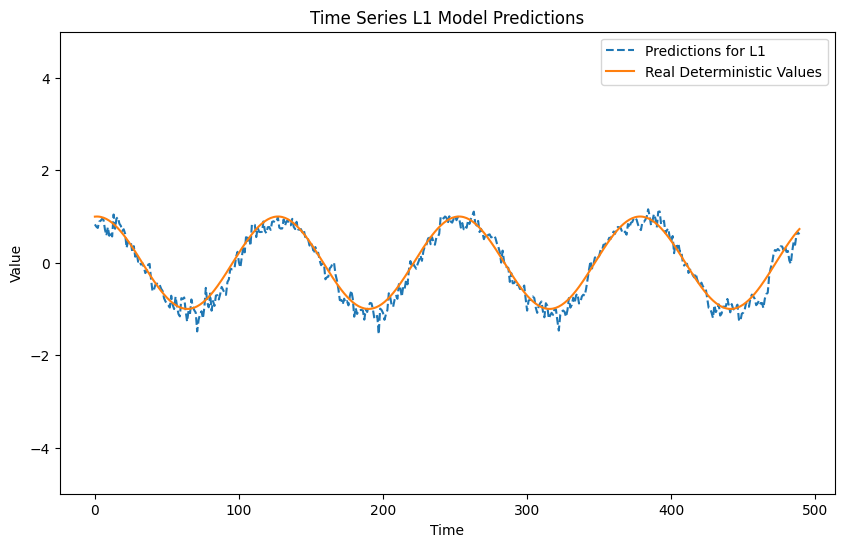

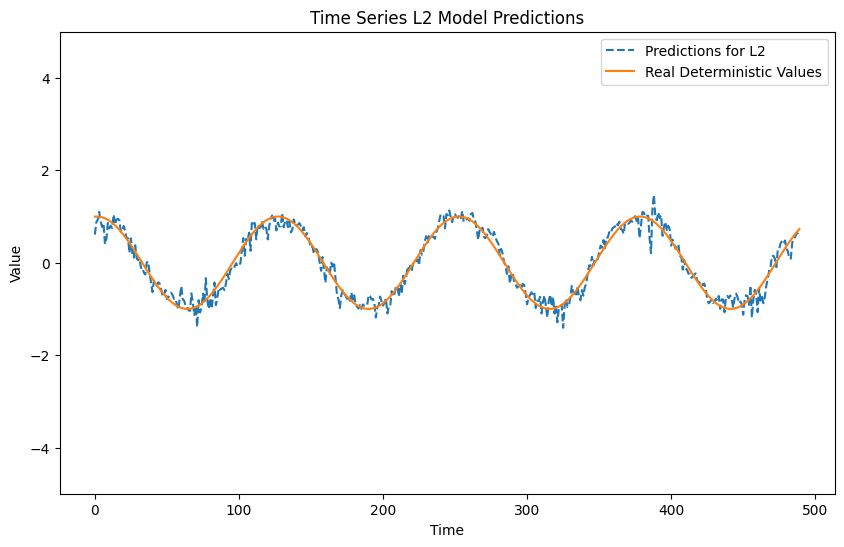

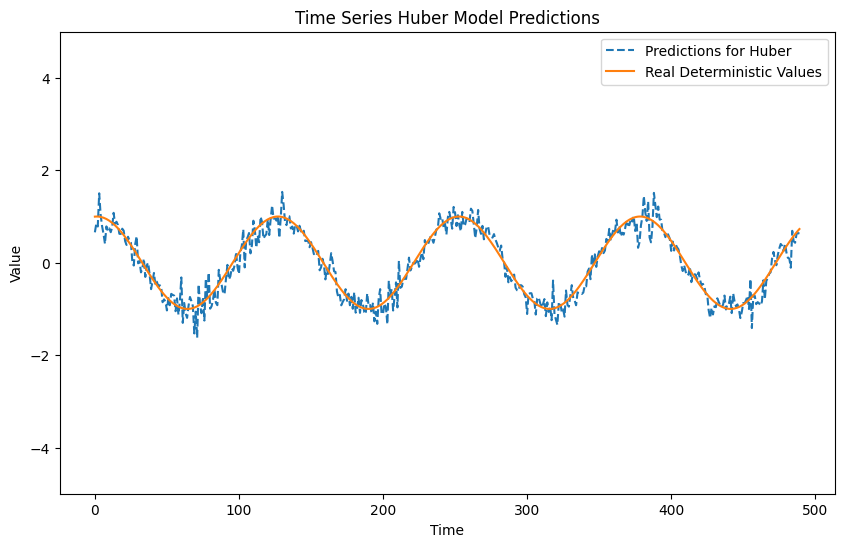

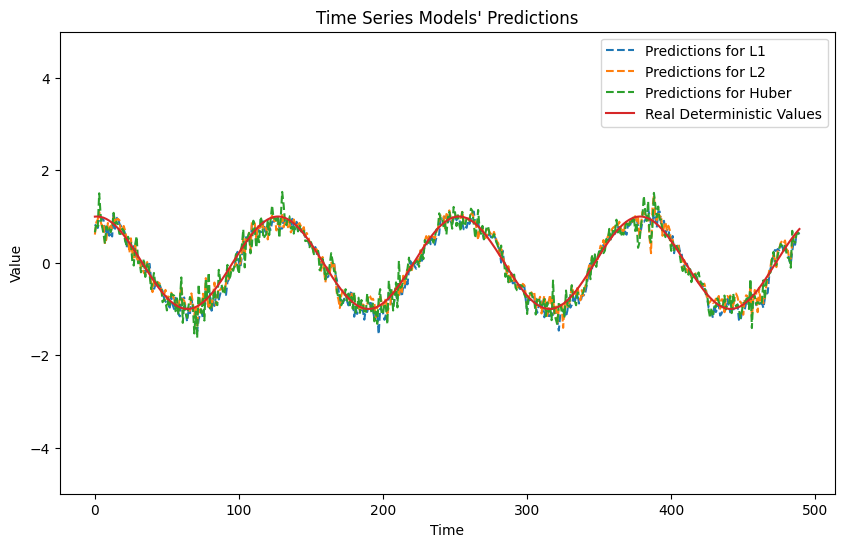

In [8]:
for k in predictions_dict.keys():

    plot_estimations(predictions=predictions_dict[k],series=series,model_name=k,use_total_series=False)

plot_multiple_estimations(pred_dict=predictions_dict,series=series,use_total_series=False)

Finally, we recover the distribution of errors through an histogram and a kernel density estimation:

Analyzing errors for L1 loss...

Mean: 0.045439970684056384 vs. Theoretical Mean: 0
Median: 0.03154162422329665 vs. Theoretical Median: 0
Standard Dev.: 0.26382162435289436 vs. Theoretical Std. Dev.: 0.25
Skew: 0.15638664278638162
Kurtosis: 0.2880890665099374
Max: 0.9111002266710654
Min: -0.657235757199139




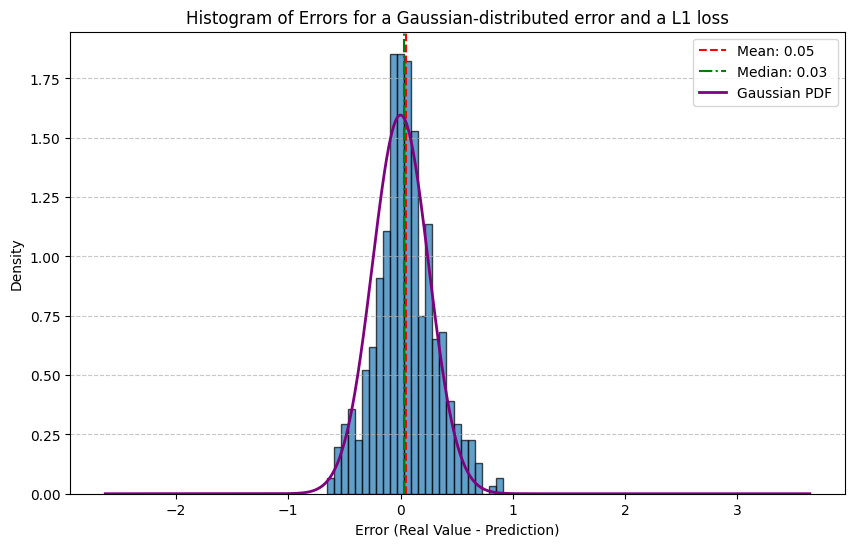

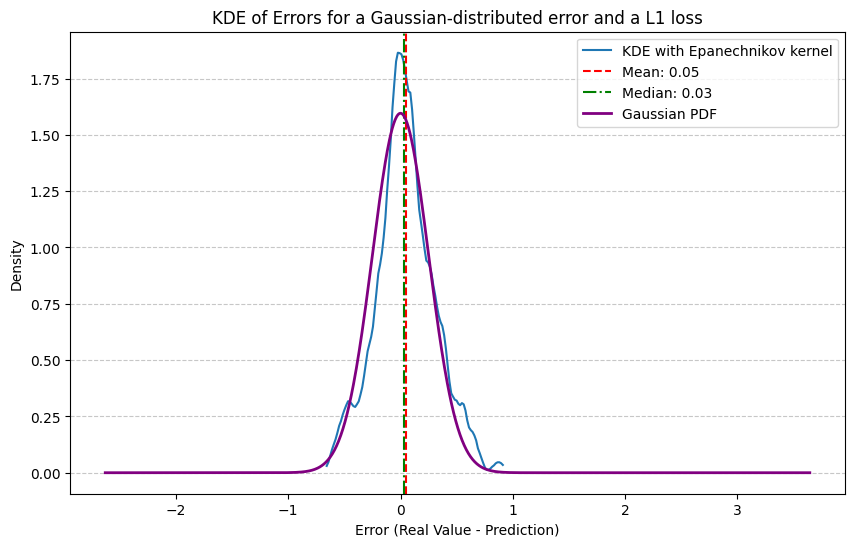

Analyzing errors for L2 loss...

Mean: -0.01680708648118141 vs. Theoretical Mean: 0
Median: -0.017709595361114494 vs. Theoretical Median: 0
Standard Dev.: 0.2214734314425044 vs. Theoretical Std. Dev.: 0.25
Skew: 0.03432599493611946
Kurtosis: -0.03134598298254687
Max: 0.6460699178220579
Min: -0.7306363142403072




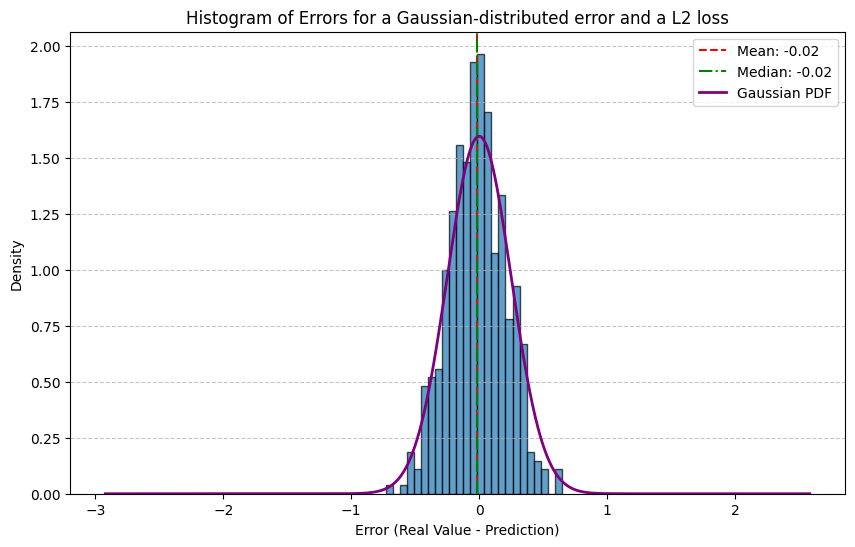

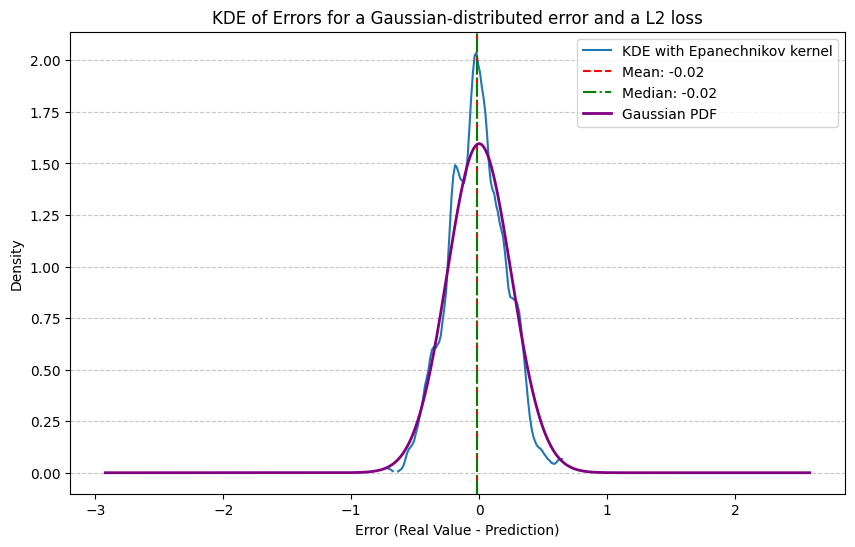

Analyzing errors for Huber loss...

Mean: 0.013359224107980423 vs. Theoretical Mean: 0
Median: 0.01870699553489119 vs. Theoretical Median: 0
Standard Dev.: 0.17074996059749833 vs. Theoretical Std. Dev.: 0.25
Skew: -0.08098362857714088
Kurtosis: 0.7554359415228995
Max: 0.7252075177237118
Min: -0.6392277038963741




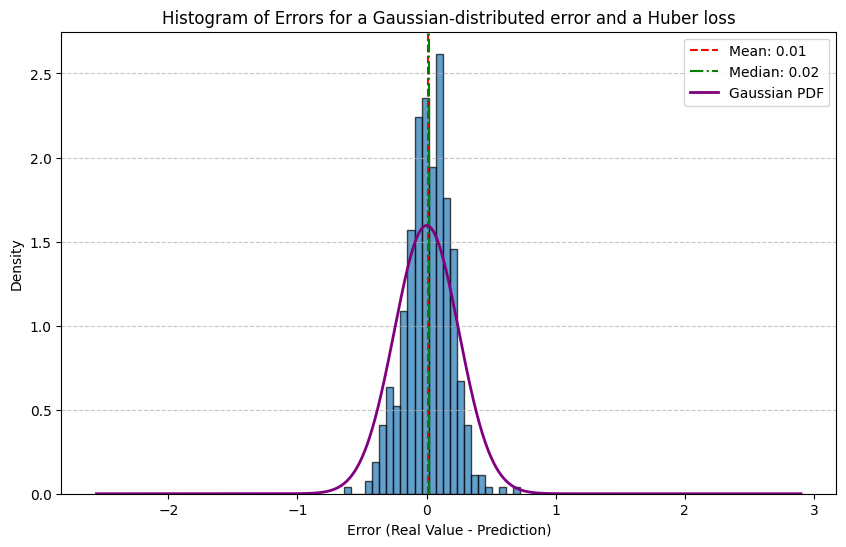

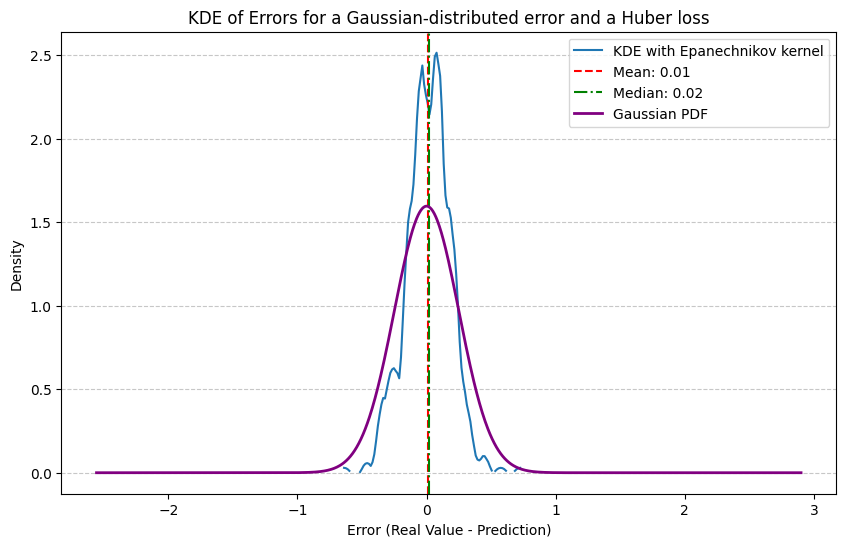

In [9]:
results = {}

for loss, predicted_values in predictions_dict.items():
    print(f"Analyzing errors for {loss} loss...\n")
    
    errors = y_test.flatten() - predicted_values.flatten()
    results[loss] = stats_results(errors,theory)

    plot_hist = RecoveryPlotHist(errors=errors,dist=norm)
    plot_hist.get_plot(loss_name=loss)

    bw = 1.06 * np.std(errors) * len(errors)**(-1/5)
    plot_kernel = RecoveryPlotKernel(errors=errors,dist=norm,kernel="epa",bw=bw)
    plot_kernel.get_plot(loss_name=loss)

**Cauchy Stochastic Process**

We simulate the time series with a Cauchy-distributed error term. In this case, the time series will be a function of the form:

$$f(t)=\sin(0.05t+1)+\varepsilon \quad \text{where} \quad \varepsilon \sim \mathcal{Cauchy}(0,1)$$

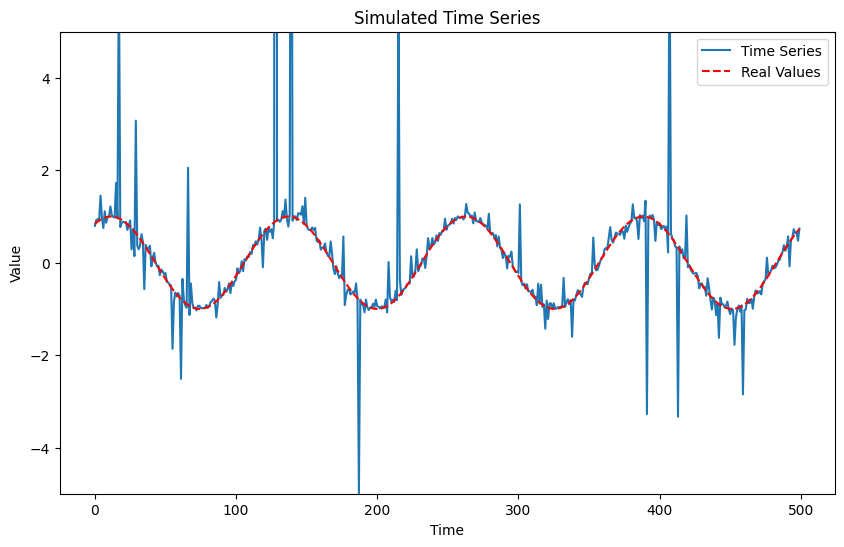

Theoretical Mean: None (Undefined)
Theoretical Std. Dev.: None (Undefined)
Theoretical Median: 0



In [10]:
n = 500
loc = 0
scale = 0.1
params = {"A": 1, "B":0.05, "C":1}
cauchy = CauchyDist({"loc": 0, "scale":0.05})

simul = TimeSeriesSimulator(determ=sinForm,noise=cauchy)
series = simul.simulate(det_params=params,n=500)
simul.plot_sim(scatter_plot=False)

theory = cauchy.theory()

print(f"Theoretical Mean: {theory["mean"]}")
print(f"Theoretical Std. Dev.: {theory["std"]}")
print(f"Theoretical Median: {theory["median"]}\n")


Then, we fit a dense neural network to our data. The architecture of this neural network is the follwoing:

- 1 linear input layer with 10 units (sequence length; can be changed)
- 1 ReLU hidden layer with 128 units
- 1 linear output layer with 1 unit
- Batch size of 16
- 50 epochs for training

We use an ADAM optimizer and we try 3 different loss funcions: the L1, the L2 and the Huber losses.

In [11]:
scaler = StandardScaler()
series["Value"] = scaler.fit_transform(series[["Value"]])
seq_length = 10
data = series["Value"].values
series["Determ"] = series["Determ"].iloc[seq_length:].reset_index(drop=True)
x, y = create_sequences_from_ts(data, seq_length)

input_shape = (seq_length,)
x = x.reshape(x.shape[0], seq_length)

# Aprendizaje de la series

vanilla_generator = VanillaNNGenerator()
model = vanilla_generator.generate(input_shape=input_shape,
                                   units={"input": seq_length, "1": 128, "output": 1},
                                   activation={"input": None, "1": "relu", "output": None})

nn_handler = NeuralNetworkHandler(model=model)
loss_functions = {
    "L1": "mae",
    "L2": "mse",
    "Huber": keras.losses.Huber(delta=0.5)  # You can adjust delta as needed
}

results = {}
predictions_dict = {}

for loss_name, loss_fn in loss_functions.items():
    print(f"\nTraining with {loss_name} loss...\n")
    
    # Compile the model with the selected loss function
    nn_handler.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.01),
        loss=loss_fn,
        metrics=["mae","mse","mape"],
        n_batches=1
    )
    
    # Train the model
    nn_handler.train(
        train_x=x,
        train_y=y,
        batch_size=16,
        epochs=50,
        shuffle=True,
        callback=None,
        y_weights=None,
        x_weights=None,
        opt_hyp=False
    )
    
    # Evaluate the model
    loss = nn_handler.evaluate(
        train_x=x,
        train_y=y,
        batch_size=16,
        x_weights=None,
        callbacks=None
    )
    print(f"Evaluation results ({loss_name}): {loss}")
    results[loss_name] = loss

    # Predict with the trained model
    predictions = nn_handler.predict(test_x=x, batch_size=16, callbacks=None)
    predicted_values = np.array(predictions["pred"])

    # Inverse transform the predictions for plotting
    predicted_values = scaler.inverse_transform(predicted_values.reshape(-1, 1))
    predictions_dict[loss_name] = predicted_values

    # Inverse transform the ground truth
    y_test = scaler.inverse_transform(y.reshape(-1, 1))

# Display evaluation results
for loss_name, evaluation_result in results.items():
    print(f"{loss_name} Loss Evaluation: {evaluation_result}")


Training with L1 loss...

Epoch 1/50


c:\Users\Iker\Desktop\Algoritmos_Perrotes\ModellingError_TS\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1778 - mae: 0.1778 - mape: 371.8264 - mse: 1.1557
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1771 - mae: 0.1771 - mape: 330.6506 - mse: 0.7812
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1373 - mae: 0.1373 - mape: 206.8429 - mse: 0.5358
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1470 - mae: 0.1470 - mape: 182.6913 - mse: 0.5471
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0927 - mae: 0.0927 - mape: 293.1653 - mse: 0.6166
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1043 - mae: 0.1043 - mape: 211.0825 - mse: 0.4881
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0715 - mae: 0.0715 - mape: 198.7767 - mse: 0.2909
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1082 - mae: 0.1082 - mape: 237.6495 - mse: 1.2743
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1821 - mae: 0.1821 - mape: 160.0637 - mse: 2.4438
Epoch 10/50
31/31 ━━━

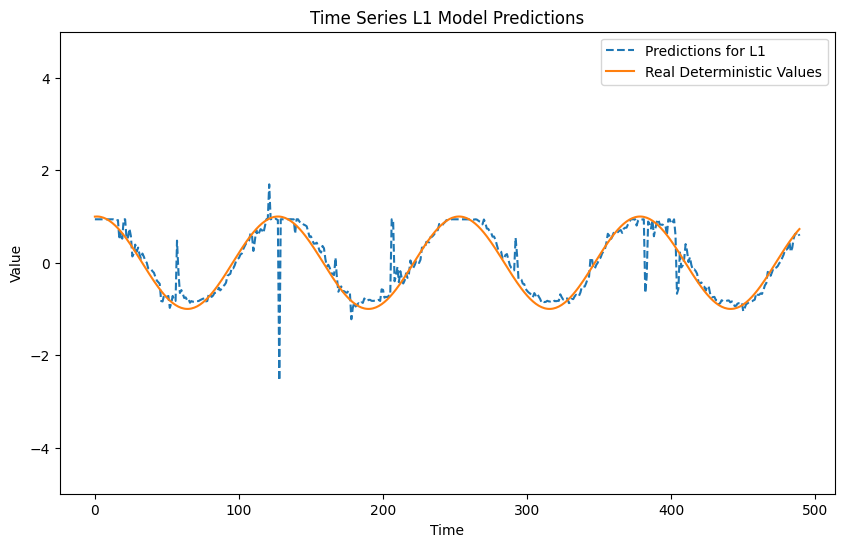

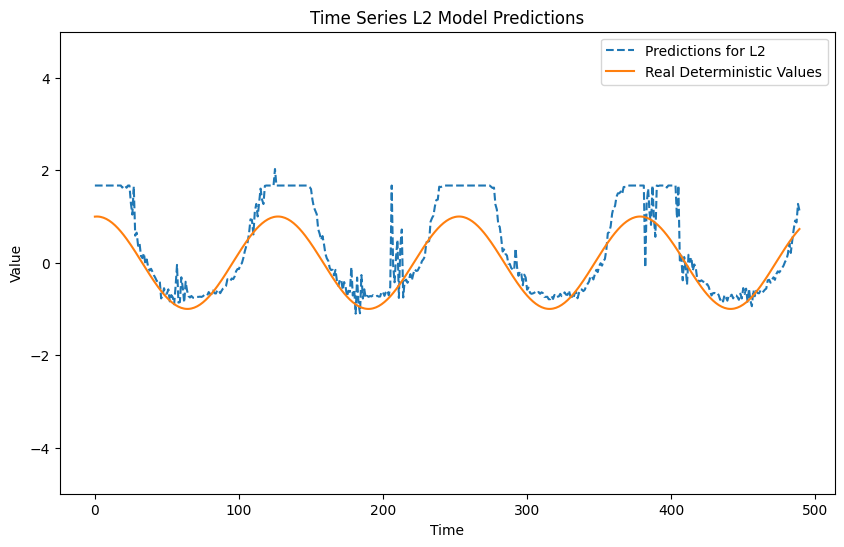

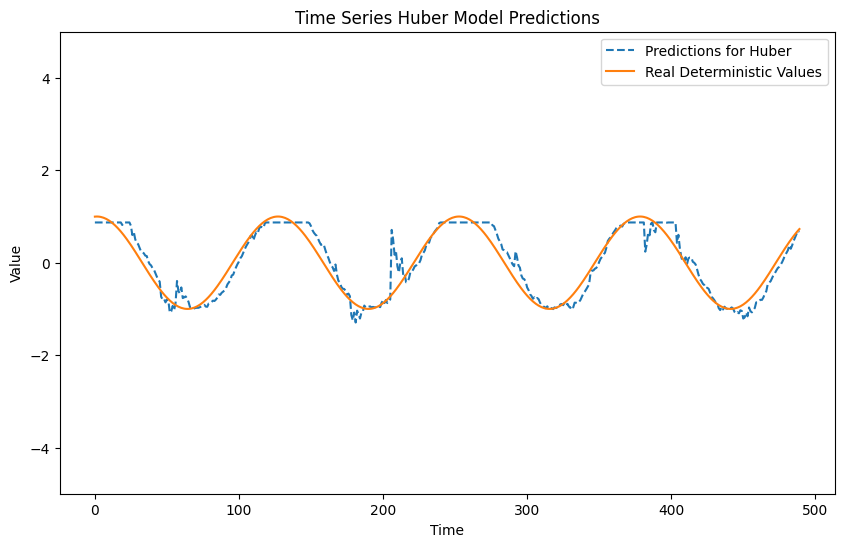

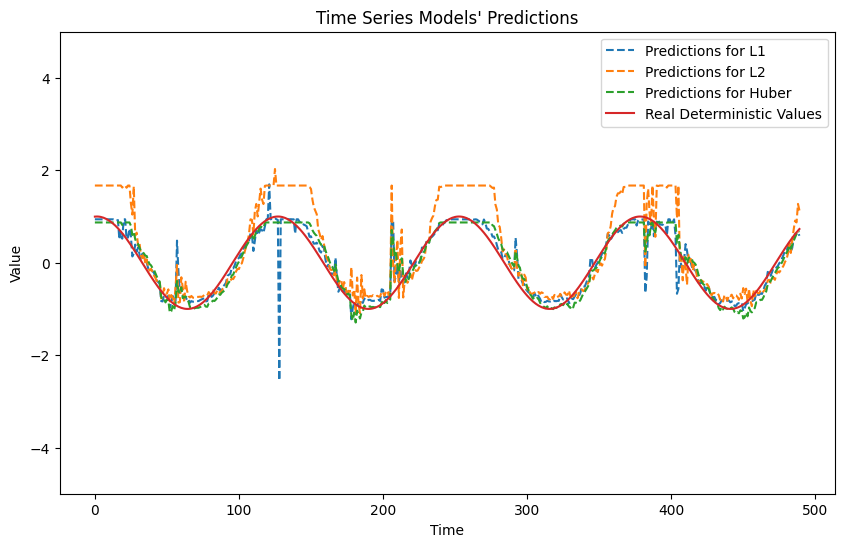

In [12]:
for k in predictions_dict.keys():

    plot_estimations(predictions=predictions_dict[k],series=series,model_name=k,use_total_series=False)

plot_multiple_estimations(pred_dict=predictions_dict,series=series,use_total_series=False)

Finally, we recover the distribution of errors through an histogram and a kernel density estimation:

Analyzing errors for L1 loss...

Mean: 0.29652054033665776 vs. Theoretical Mean: None (Undefined)
Median: -0.02944859903618413 vs. Theoretical Median: 0
Standard Dev.: 6.20825215153082 vs. Theoretical Std. Dev.: None (Undefined)
Skew: 21.242634976182543
Kurtosis: 459.91877832845915
Max: 135.77652325521595
Min: -4.340280497852421




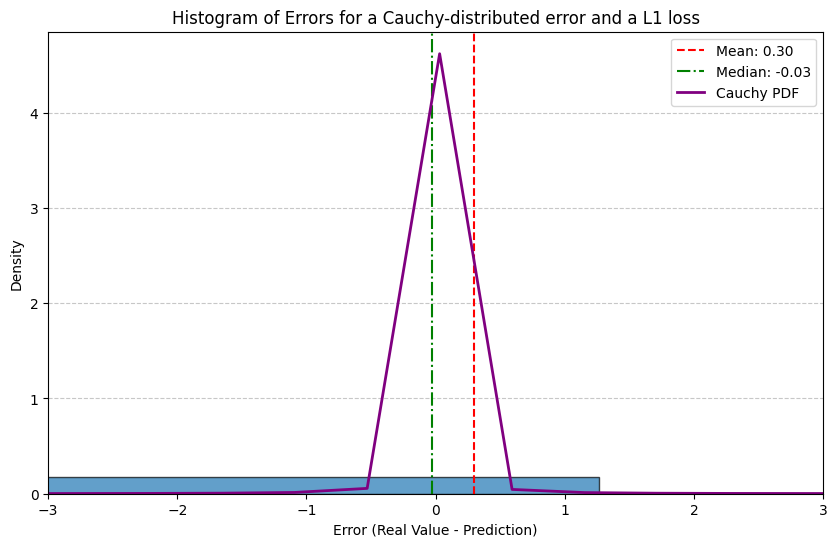

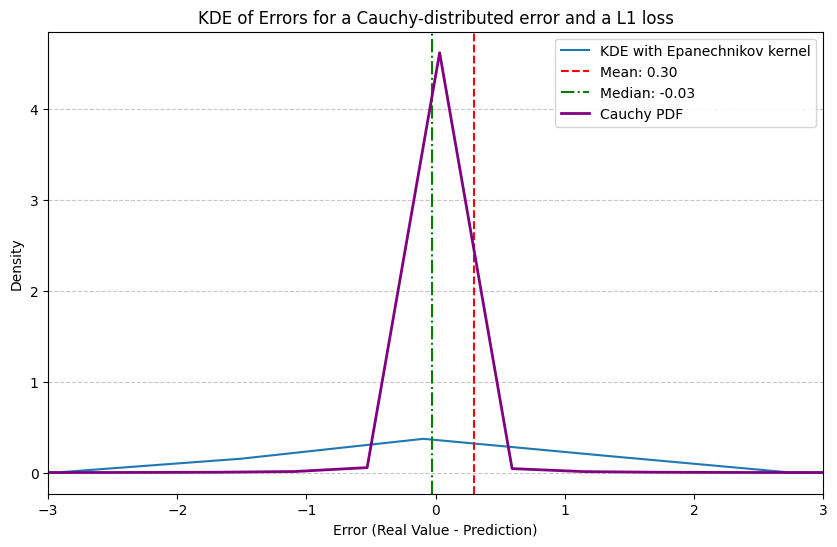

Analyzing errors for L2 loss...

Mean: 0.0018273202520487017 vs. Theoretical Mean: None (Undefined)
Median: -0.2335803413026729 vs. Theoretical Median: 0
Standard Dev.: 6.187611164457554 vs. Theoretical Std. Dev.: None (Undefined)
Skew: 21.175686258232602
Kurtosis: 458.09713992507864
Max: 134.89890470396168
Min: -5.002066289170024




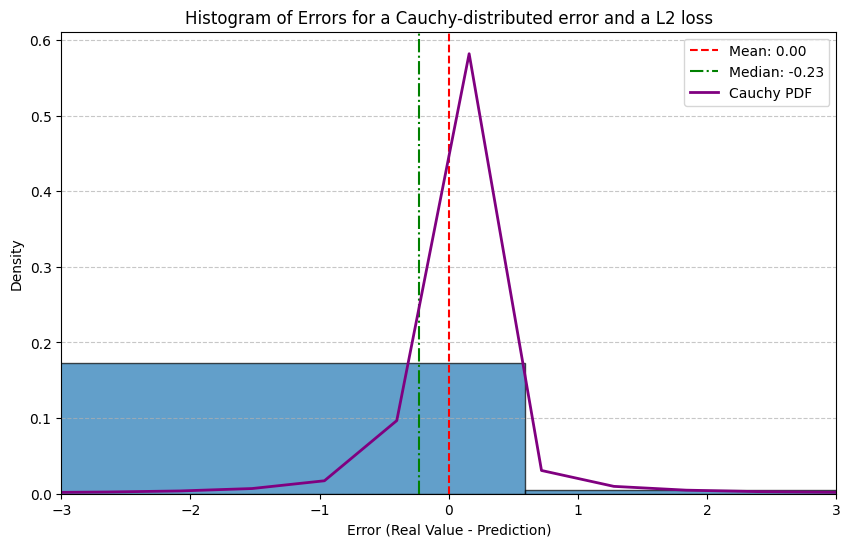

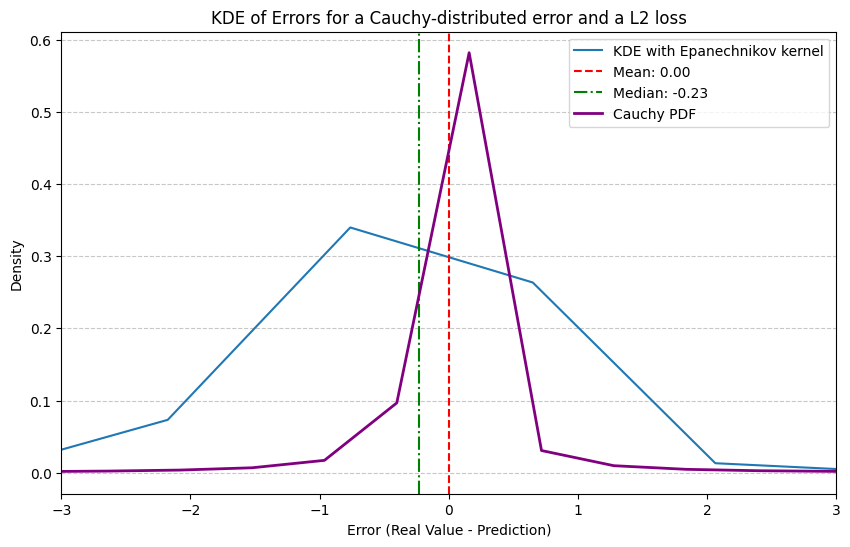

Analyzing errors for Huber loss...

Mean: 0.31398338511743706 vs. Theoretical Mean: None (Undefined)
Median: 0.02105961890563912 vs. Theoretical Median: 0
Standard Dev.: 6.201917427569669 vs. Theoretical Std. Dev.: None (Undefined)
Skew: 21.266136143395414
Kurtosis: 460.6089015426557
Max: 135.70609983097202
Min: -4.263180161300755




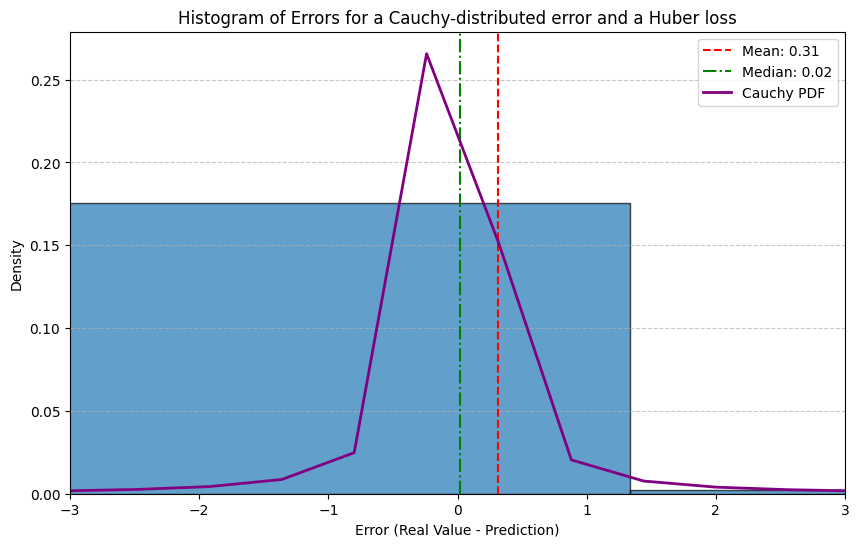

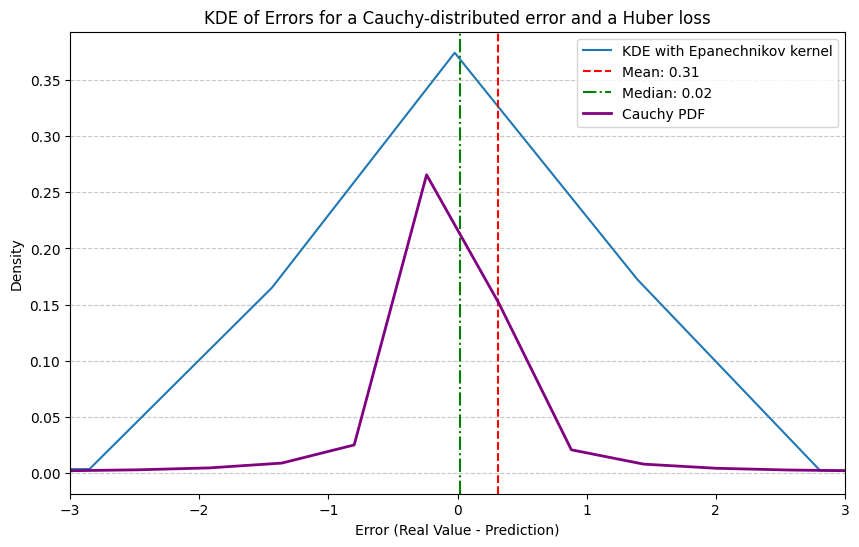

In [13]:
results = {}

for loss, predicted_values in predictions_dict.items():
    print(f"Analyzing errors for {loss} loss...\n")
    
    errors = y_test.flatten() - predicted_values.flatten()
    results[loss] = stats_results(errors,theory)

    plot_hist = RecoveryPlotHist(errors=errors,dist=cauchy)
    plot_hist.get_plot(loss_name=loss,x_limits=[-3,3])

    bw = 1.06 * np.std(errors) * len(errors)**(-1/5)
    plot_kernel = RecoveryPlotKernel(errors=errors,dist=cauchy,kernel="epa",bw=bw)
    plot_kernel.get_plot(loss_name=loss,x_limits=[-3,3])

**Gumbel Stochastic Process**

We simulate the time series with a Gumbel-distributed error term. In this case, the time series will be a function of the form:

$$f(t)=\sin(0.05t+1)+\varepsilon \quad \text{where} \quad \varepsilon \sim \mathcal{Gumbel}(1.5,3.5)$$

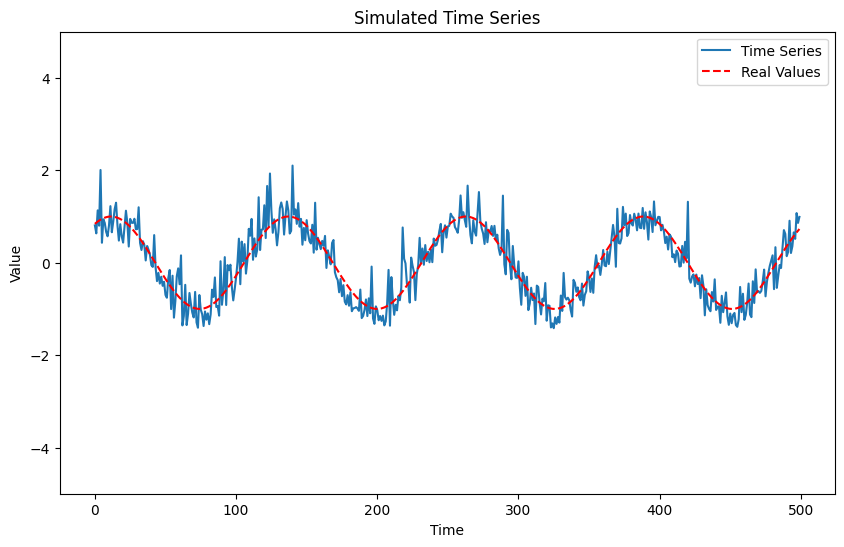

Theoretical Mean: 3.1443039162253834
Theoretical Std. Dev.: 0.320637457540466
Theoretical Median: 3.091628230145416



In [14]:
n = 500
loc = 0
scale = 0.1
params = {"A": 1, "B":0.05, "C":1}
gumbel = GumbelDist({"loc": 3, "scale":0.25}, demean=True)

simul = TimeSeriesSimulator(determ=sinForm, noise=gumbel)
series = simul.simulate(det_params=params,n=500)
simul.plot_sim(scatter_plot=False)

theory = gumbel.theory()

print(f"Theoretical Mean: {theory["mean"]}")
print(f"Theoretical Std. Dev.: {theory["std"]}")
print(f"Theoretical Median: {theory["median"]}\n")


Then, we fit a dense neural network to our data. The architecture of this neural network is the follwoing:

- 1 linear input layer with 10 units (sequence length; can be changed)
- 1 ReLU hidden layer with 128 units
- 1 linear output layer with 1 unit
- Batch size of 16
- 50 epochs for training

We use an ADAM optimizer and we try 3 different loss funcions: the L1, the L2 and the Huber losses.

In [15]:
scaler = StandardScaler()
series["Value"] = scaler.fit_transform(series[["Value"]])
seq_length = 10
data = series["Value"].values
series["Determ"] = series["Determ"].iloc[seq_length:].reset_index(drop=True)
x, y = create_sequences_from_ts(data, seq_length)

input_shape = (seq_length,)
x = x.reshape(x.shape[0], seq_length)

# Aprendizaje de la series

vanilla_generator = VanillaNNGenerator()
model = vanilla_generator.generate(input_shape=input_shape,
                                   units={"input": seq_length, "1": 128, "output": 1},
                                   activation={"input": None, "1": "relu", "output": None})

nn_handler = NeuralNetworkHandler(model=model)
loss_functions = {
    "L1": "mae",
    "L2": "mse",
    "Huber": keras.losses.Huber(delta=0.5)  # You can adjust delta as needed
}

results = {}
predictions_dict = {}

for loss_name, loss_fn in loss_functions.items():
    print(f"\nTraining with {loss_name} loss...\n")
    
    # Compile the model with the selected loss function
    nn_handler.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.01),
        loss=loss_fn,
        metrics=["mae","mse","mape"],
        n_batches=1
    )
    
    # Train the model
    nn_handler.train(
        train_x=x,
        train_y=y,
        batch_size=16,
        epochs=50,
        shuffle=True,
        callback=None,
        y_weights=None,
        x_weights=None,
        opt_hyp=False
    )
    
    # Evaluate the model
    loss = nn_handler.evaluate(
        train_x=x,
        train_y=y,
        batch_size=16,
        x_weights=None,
        callbacks=None
    )
    print(f"Evaluation results ({loss_name}): {loss}")
    results[loss_name] = loss

    # Predict with the trained model
    predictions = nn_handler.predict(test_x=x, batch_size=16, callbacks=None)
    predicted_values = np.array(predictions["pred"])

    # Inverse transform the predictions for plotting
    predicted_values = scaler.inverse_transform(predicted_values.reshape(-1, 1))
    predictions_dict[loss_name] = predicted_values

    # Inverse transform the ground truth
    y_test = scaler.inverse_transform(y.reshape(-1, 1))

# Display evaluation results
for loss_name, evaluation_result in results.items():
    print(f"{loss_name} Loss Evaluation: {evaluation_result}")


Training with L1 loss...

Epoch 1/50


c:\Users\Iker\Desktop\Algoritmos_Perrotes\ModellingError_TS\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4901 - mae: 0.4901 - mape: 147.2752 - mse: 0.3923
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3724 - mae: 0.3724 - mape: 119.7448 - mse: 0.2264
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3933 - mae: 0.3933 - mape: 135.2991 - mse: 0.2511
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3694 - mae: 0.3694 - mape: 144.2010 - mse: 0.2212
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3792 - mae: 0.3792 - mape: 118.5340 - mse: 0.2590
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3834 - mae: 0.3834 - mape: 146.1237 - mse: 0.2339
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3311 - mae: 0.3311 - mape: 106.1600 - mse: 0.1919
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3774 - mae: 0.3774 - mape: 134.6821 - mse: 0.2381
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3438 - mae: 0.3438 - mape: 106.3866 - mse: 0.2011
Epoch 10/50
31/31 ━━━

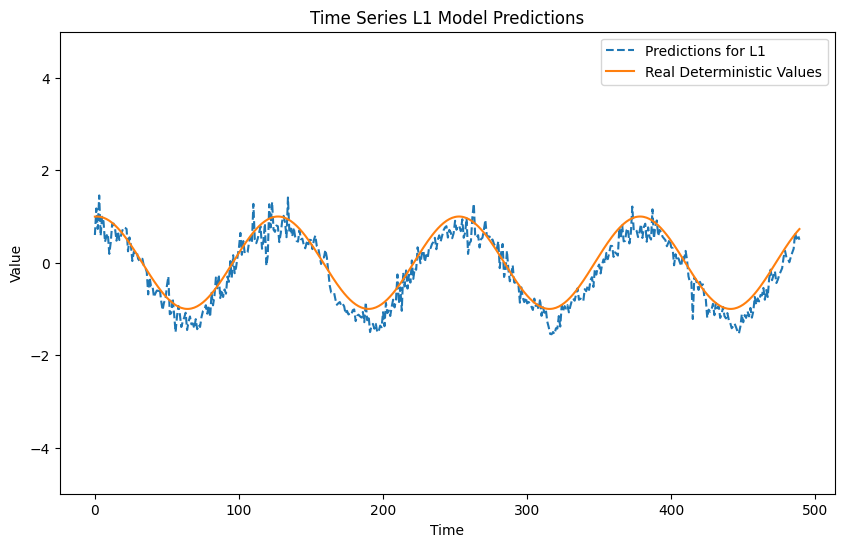

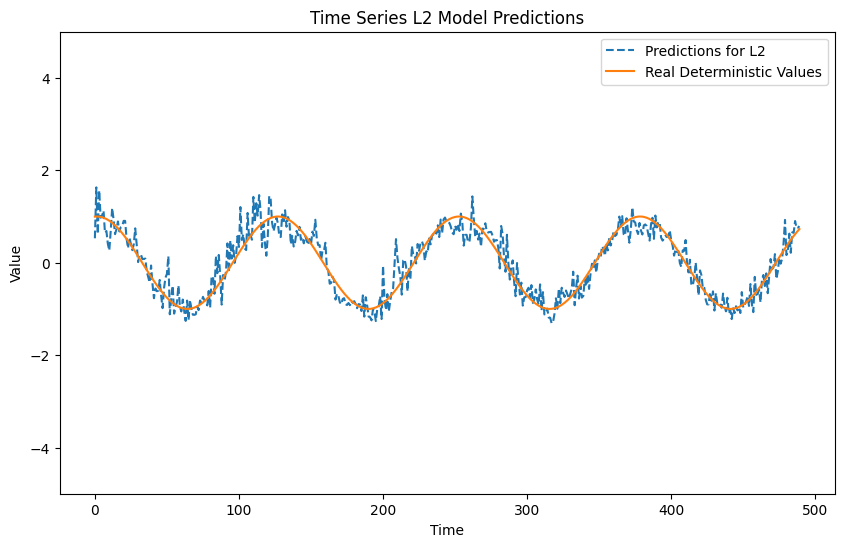

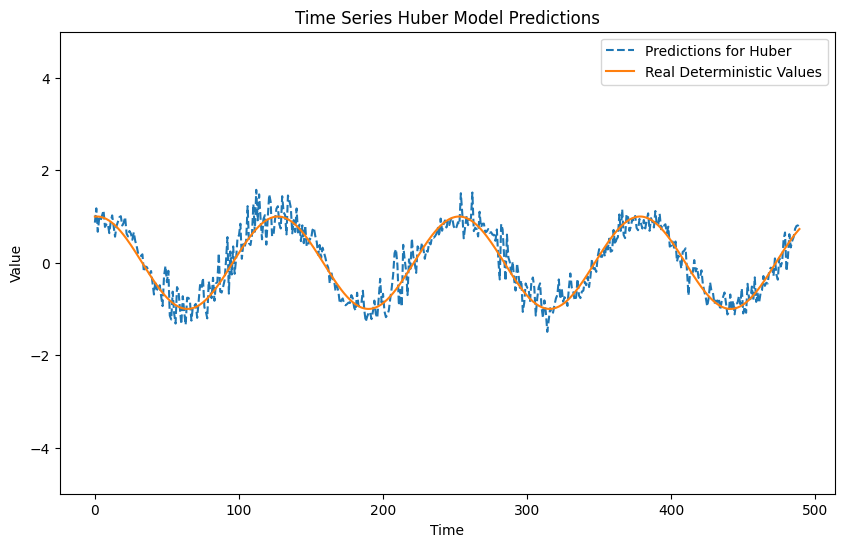

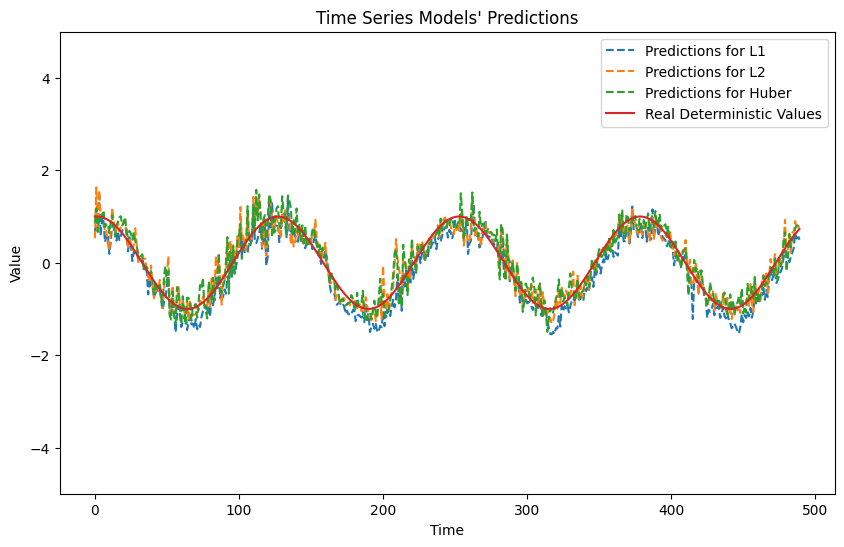

In [16]:
for k in predictions_dict.keys():

    plot_estimations(predictions=predictions_dict[k],series=series,model_name=k,use_total_series=False)

plot_multiple_estimations(pred_dict=predictions_dict,series=series,use_total_series=False)

Finally, we recover the distribution of errors through an histogram and a kernel density estimation:

Analyzing errors for L1 loss...

Mean: 0.171369618921573 vs. Theoretical Mean: 3.1443039162253834
Median: 0.14392846181979083 vs. Theoretical Median: 3.091628230145416
Standard Dev.: 0.31894728900358343 vs. Theoretical Std. Dev.: 0.320637457540466
Skew: 0.8364361205089053
Kurtosis: 1.906604762446639
Max: 1.729604763762787
Min: -0.6708626853393245




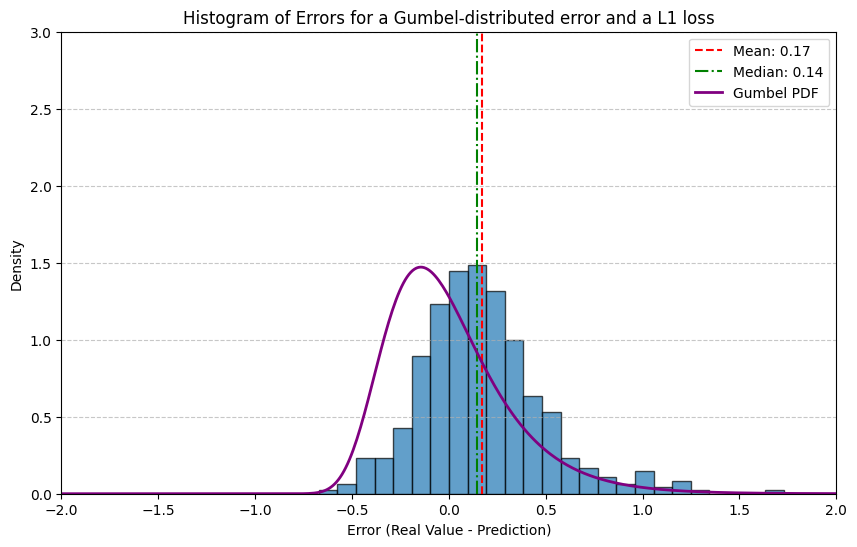

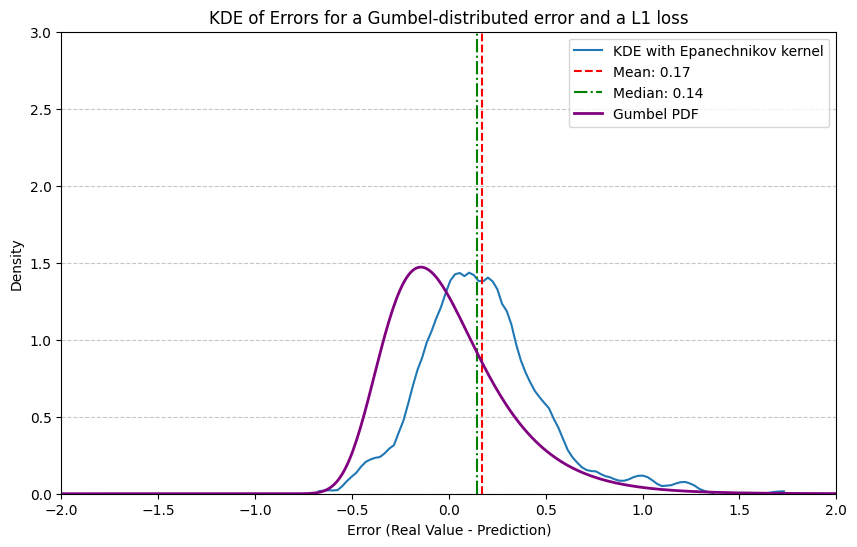

Analyzing errors for L2 loss...

Mean: -0.022142884890706628 vs. Theoretical Mean: 3.1443039162253834
Median: -0.04118025019086902 vs. Theoretical Median: 3.091628230145416
Standard Dev.: 0.2554499181185345 vs. Theoretical Std. Dev.: 0.320637457540466
Skew: 0.48603491198615684
Kurtosis: 1.120281755549975
Max: 1.0576689697179344
Min: -0.7161791145782972




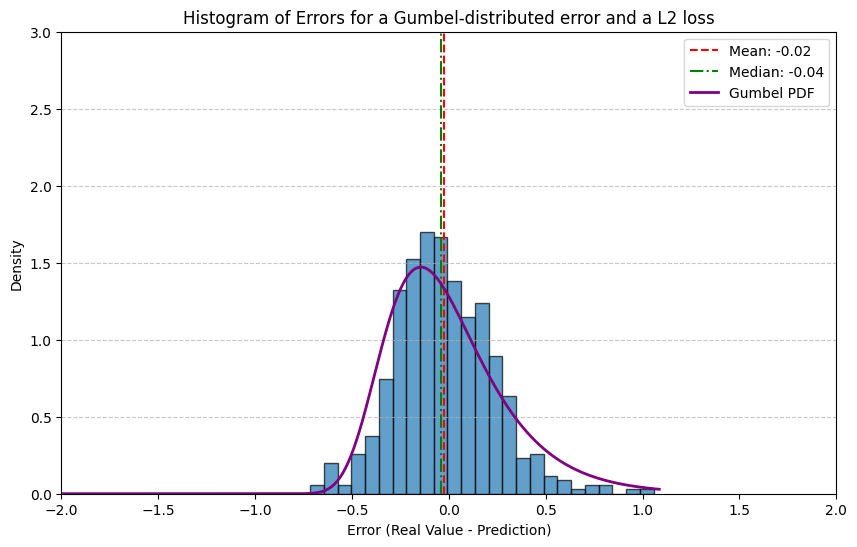

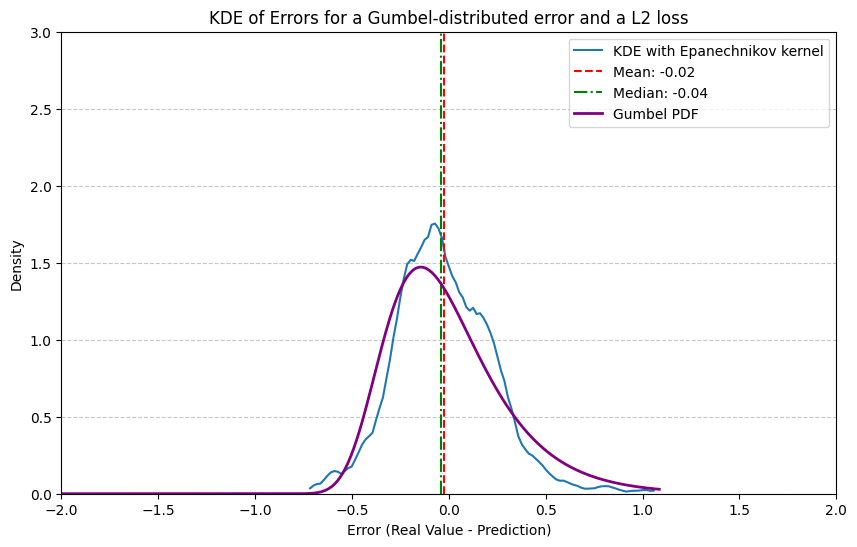

Analyzing errors for Huber loss...

Mean: -0.04732229136666662 vs. Theoretical Mean: 3.1443039162253834
Median: -0.06514144047616582 vs. Theoretical Median: 3.091628230145416
Standard Dev.: 0.22314323254150334 vs. Theoretical Std. Dev.: 0.320637457540466
Skew: 0.5506410519832984
Kurtosis: 1.0795433455466403
Max: 1.0077495588114243
Min: -0.6702227698730159




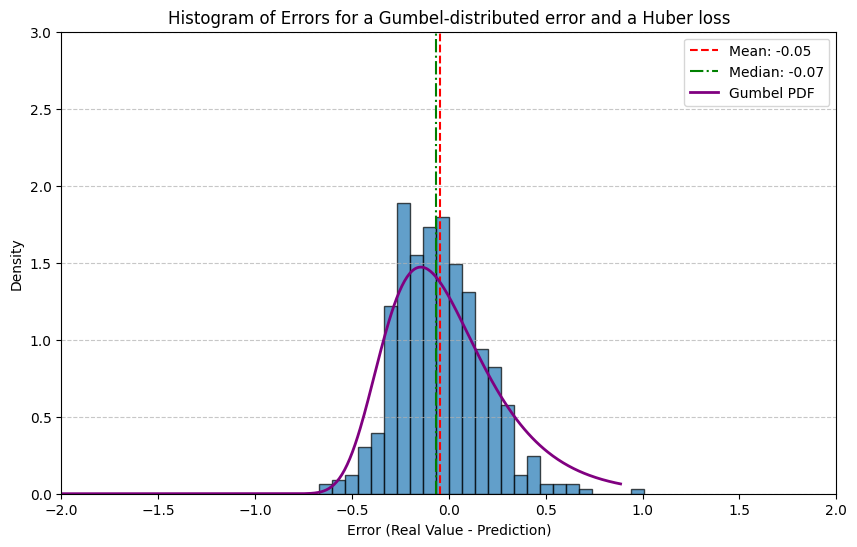

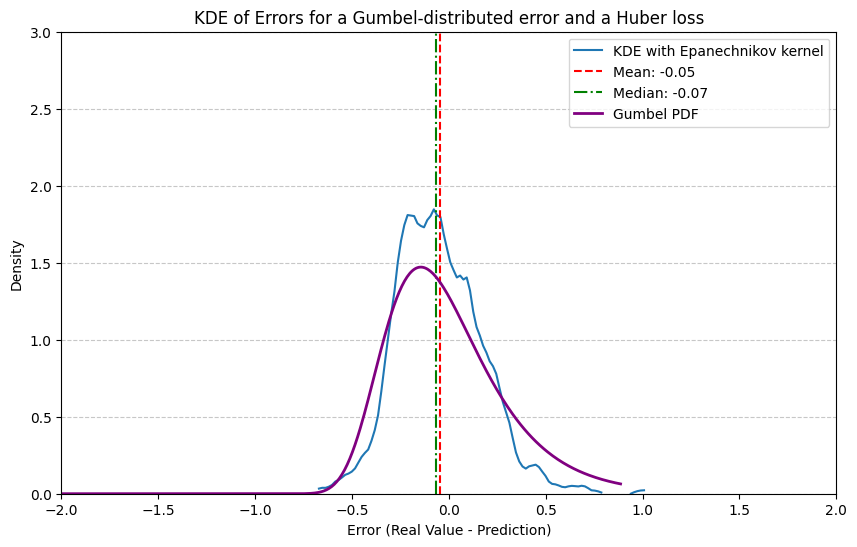

In [17]:
results = {}

for loss, predicted_values in predictions_dict.items():
    print(f"Analyzing errors for {loss} loss...\n")
    
    errors = y_test.flatten() - predicted_values.flatten()
    results[loss] = stats_results(errors,theory)

    plot_hist = RecoveryPlotHist(errors=errors,dist=gumbel)
    plot_hist.get_plot(loss_name=loss,x_limits=[-2,2],y_limits=[0,3])

    bw = 1.06 * np.std(errors) * len(errors)**(-1/5)
    plot_kernel = RecoveryPlotKernel(errors=errors,dist=gumbel,kernel="epa",bw=bw)
    plot_kernel.get_plot(loss_name=loss,x_limits=[-2,2],y_limits=[0,3])

**Log-Normal Stochastic Process**

We simulate the time series with a Lognormal-distributed error term. In this case, the time series will be a function of the form:

$$f(t)=\sin(0.05t+1)+\varepsilon \quad \text{where} \quad \varepsilon \sim \mathcal{logN}(-2.5,1)$$

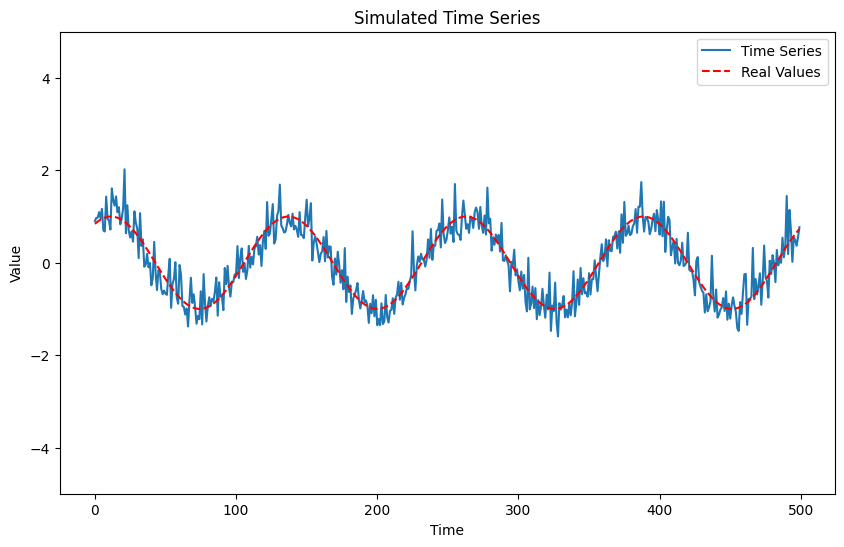

Theoretical Mean: 1.046027859908717
Theoretical Std. Dev.: 0.3210032389503257
Theoretical Median: 1.0



In [18]:
n = 500
loc = 0
scale = 0.1
params = {"A": 1, "B":0.05, "C":1}
lognorm = LogNormalDist({"mean": 0, "sigma": 0.3},demean=True)

simul = TimeSeriesSimulator(determ=sinForm,noise=lognorm)
series = simul.simulate(det_params=params,n=500)
simul.plot_sim(scatter_plot=False)

theory = lognorm.theory()

print(f"Theoretical Mean: {theory["mean"]}")
print(f"Theoretical Std. Dev.: {theory["std"]}")
print(f"Theoretical Median: {theory["median"]}\n")


Then, we fit a dense neural network to our data. The architecture of this neural network is the follwoing:

- 1 linear input layer with 10 units (sequence length; can be changed)
- 1 ReLU hidden layer with 128 units
- 1 linear output layer with 1 unit
- Batch size of 16
- 50 epochs for training

We use an ADAM optimizer and we try 3 different loss funcions: the L1, the L2 and the Huber losses.

In [19]:
scaler = StandardScaler()
series["Value"] = scaler.fit_transform(series[["Value"]])
seq_length = 10
data = series["Value"].values
series["Determ"] = series["Determ"].iloc[seq_length:].reset_index(drop=True)
x, y = create_sequences_from_ts(data, seq_length)

input_shape = (seq_length,)
x = x.reshape(x.shape[0], seq_length)

# Aprendizaje de la series

vanilla_generator = VanillaNNGenerator()
model = vanilla_generator.generate(input_shape=input_shape,
                                   units={"input": seq_length, "1": 128, "output": 1},
                                   activation={"input": None, "1": "relu", "output": None})

nn_handler = NeuralNetworkHandler(model=model)
loss_functions = {
    "L1": "mae",
    "L2": "mse",
    "Huber": keras.losses.Huber(delta=0.5)  # You can adjust delta as needed
}

results = {}
predictions_dict = {}

for loss_name, loss_fn in loss_functions.items():
    print(f"\nTraining with {loss_name} loss...\n")
    
    # Compile the model with the selected loss function
    nn_handler.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.01),
        loss=loss_fn,
        metrics=["mae","mse","mape"],
        n_batches=1
    )
    
    # Train the model
    nn_handler.train(
        train_x=x,
        train_y=y,
        batch_size=16,
        epochs=50,
        shuffle=True,
        callback=None,
        y_weights=None,
        x_weights=None,
        opt_hyp=False
    )
    
    # Evaluate the model
    loss = nn_handler.evaluate(
        train_x=x,
        train_y=y,
        batch_size=16,
        x_weights=None,
        callbacks=None
    )
    print(f"Evaluation results ({loss_name}): {loss}")
    results[loss_name] = loss

    # Predict with the trained model
    predictions = nn_handler.predict(test_x=x, batch_size=16, callbacks=None)
    predicted_values = np.array(predictions["pred"])

    # Inverse transform the predictions for plotting
    predicted_values = scaler.inverse_transform(predicted_values.reshape(-1, 1))
    predictions_dict[loss_name] = predicted_values

    # Inverse transform the ground truth
    y_test = scaler.inverse_transform(y.reshape(-1, 1))

# Display evaluation results
for loss_name, evaluation_result in results.items():
    print(f"{loss_name} Loss Evaluation: {evaluation_result}")


Training with L1 loss...

Epoch 1/50


c:\Users\Iker\Desktop\Algoritmos_Perrotes\ModellingError_TS\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5803 - mae: 0.5803 - mape: 265.6602 - mse: 0.4959
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4051 - mae: 0.4051 - mape: 152.8204 - mse: 0.2579
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3711 - mae: 0.3711 - mape: 141.2720 - mse: 0.2296
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3715 - mae: 0.3715 - mape: 197.8794 - mse: 0.2296
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3711 - mae: 0.3711 - mape: 196.4735 - mse: 0.2208
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3536 - mae: 0.3536 - mape: 150.9328 - mse: 0.2082
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3461 - mae: 0.3461 - mape: 124.2831 - mse: 0.2062
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3619 - mae: 0.3619 - mape: 143.8708 - mse: 0.2110
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3981 - mae: 0.3981 - mape: 293.7682 - mse: 0.2528
Epoch 10/50
31/31 ━━━

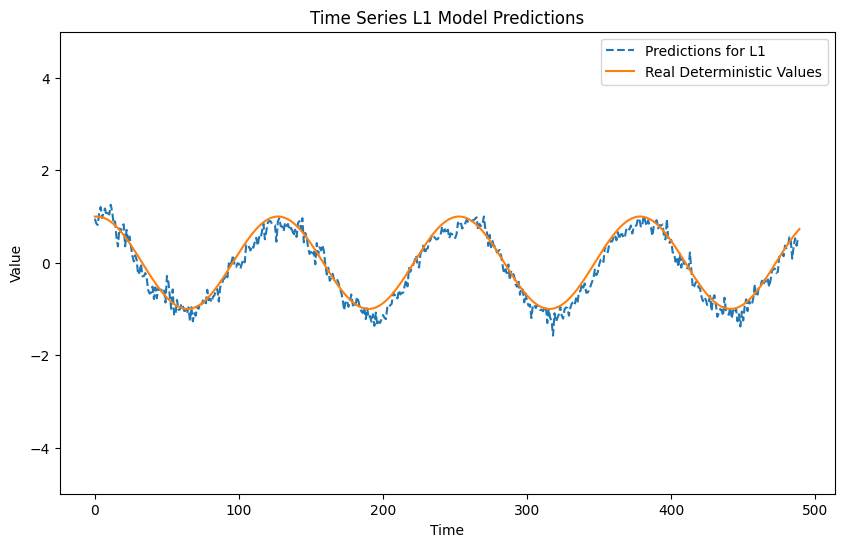

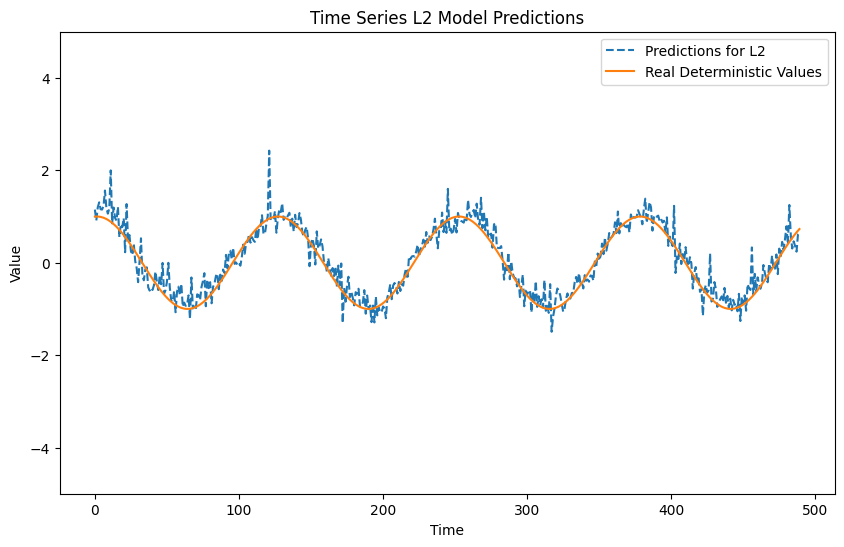

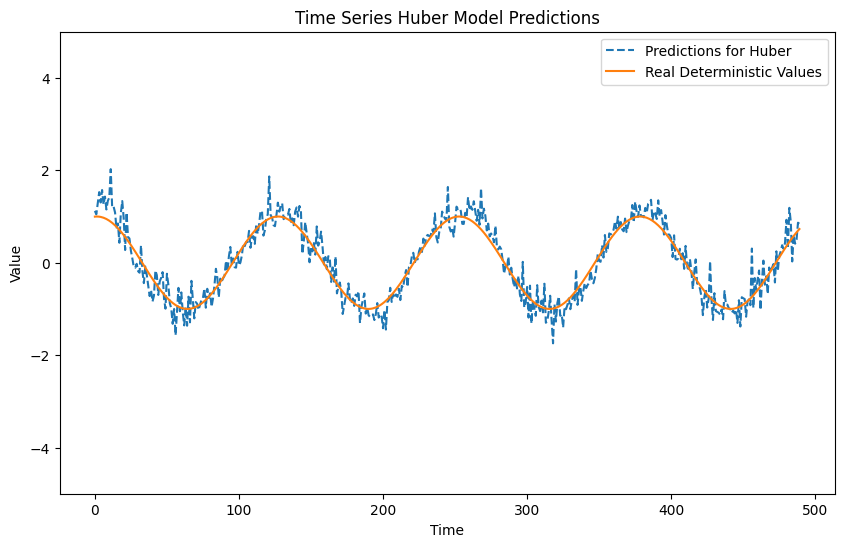

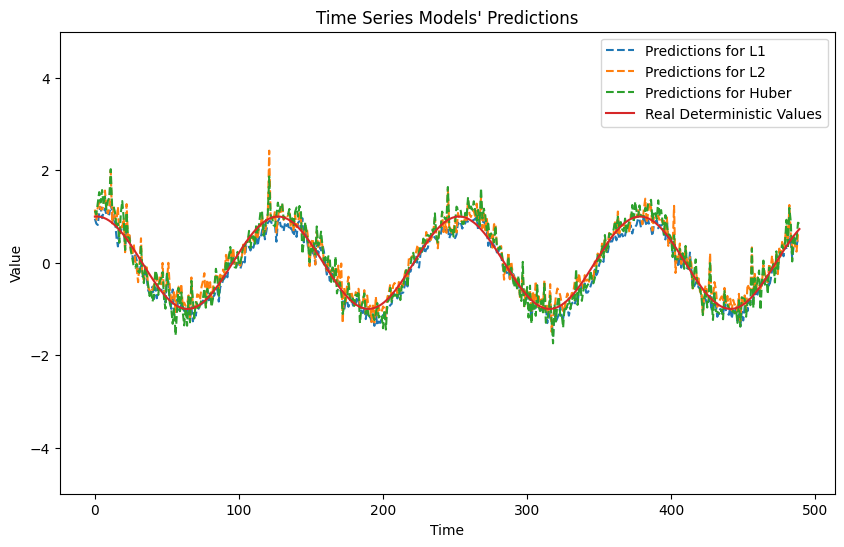

In [20]:
for k in predictions_dict.keys():

    plot_estimations(predictions=predictions_dict[k],series=series,model_name=k,use_total_series=False)

plot_multiple_estimations(pred_dict=predictions_dict,series=series,use_total_series=False)

Finally, we recover the distribution of errors through an histogram and a kernel density estimation:

Analyzing errors for L1 loss...

Mean: 0.09417453743329292 vs. Theoretical Mean: 1.046027859908717
Median: 0.05590994835943269 vs. Theoretical Median: 1.0
Standard Dev.: 0.29925232413325087 vs. Theoretical Std. Dev.: 0.3210032389503257
Skew: 0.6389498367116523
Kurtosis: 1.2641937790962299
Max: 1.2356349042470427
Min: -0.9155774332626362




c:\Users\Iker\Desktop\Algoritmos_Perrotes\ModellingError_TS\src\Probability\classes.py:196: RuntimeWarning: invalid value encountered in log
  (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mean) ** 2) / (2 * sigma ** 2)),


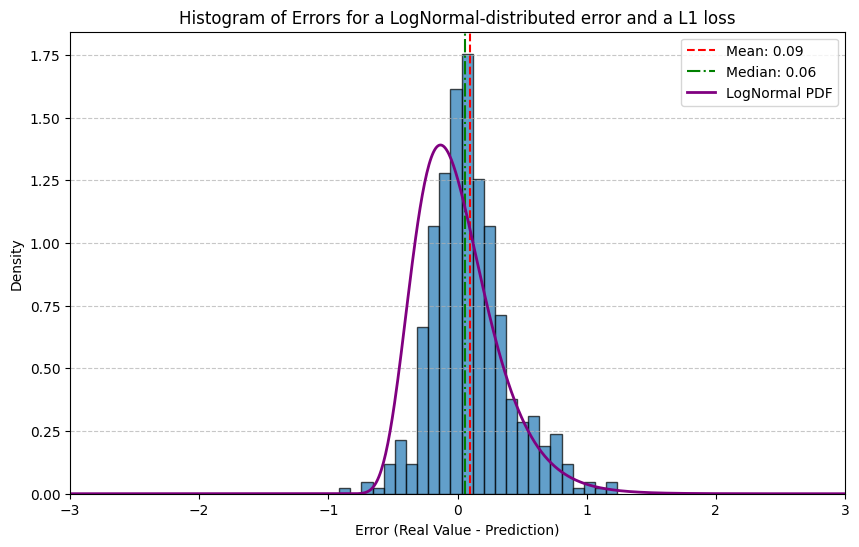

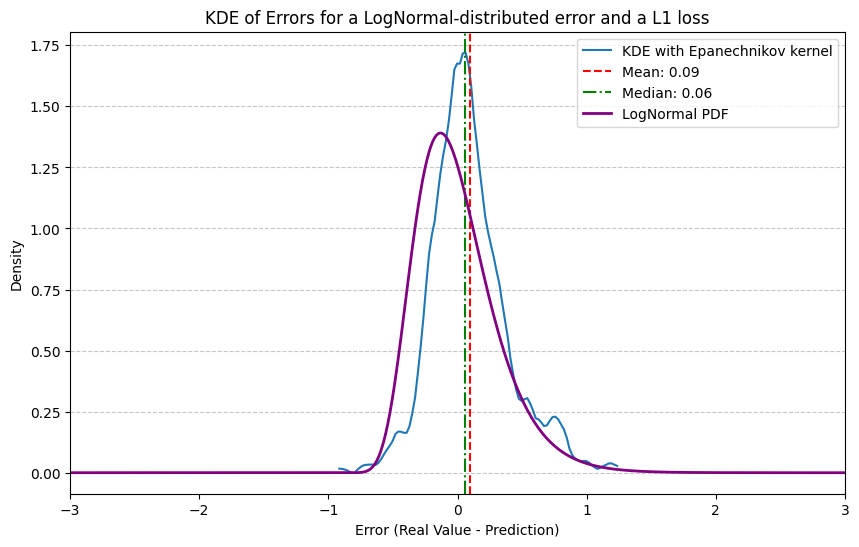

Analyzing errors for L2 loss...

Mean: -0.08675007632722526 vs. Theoretical Mean: 1.046027859908717
Median: -0.10819446693039741 vs. Theoretical Median: 1.0
Standard Dev.: 0.23611330706946984 vs. Theoretical Std. Dev.: 0.3210032389503257
Skew: 0.5009985393844318
Kurtosis: 1.0284469067575621
Max: 0.9310280709822571
Min: -0.7346515019389614




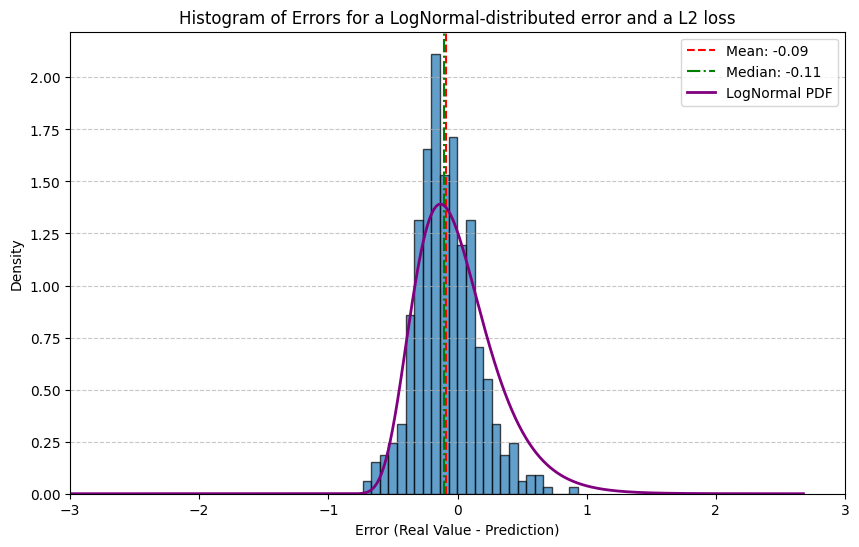

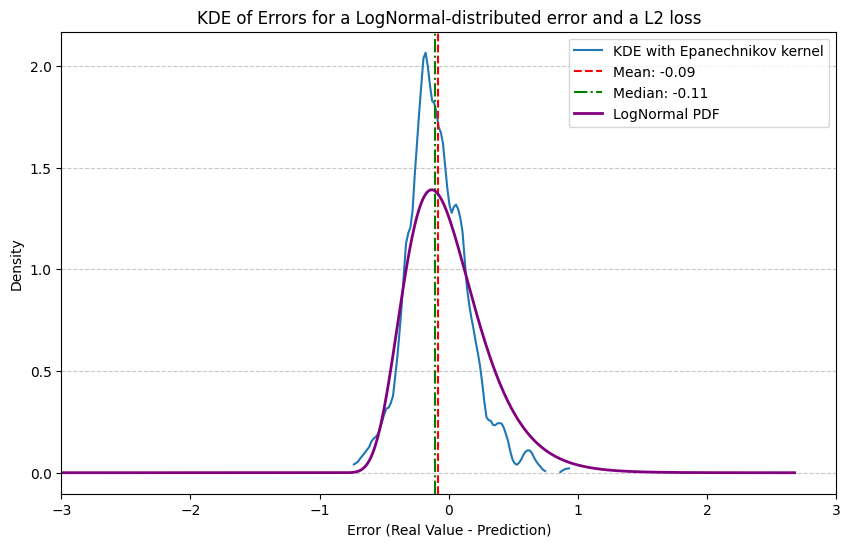

Analyzing errors for Huber loss...

Mean: -0.0388446398782443 vs. Theoretical Mean: 1.046027859908717
Median: -0.04112282545332485 vs. Theoretical Median: 1.0
Standard Dev.: 0.2056290316090849 vs. Theoretical Std. Dev.: 0.3210032389503257
Skew: 0.2843844379628679
Kurtosis: 1.8195138161057685
Max: 0.9707263737280762
Min: -0.7576785044123621




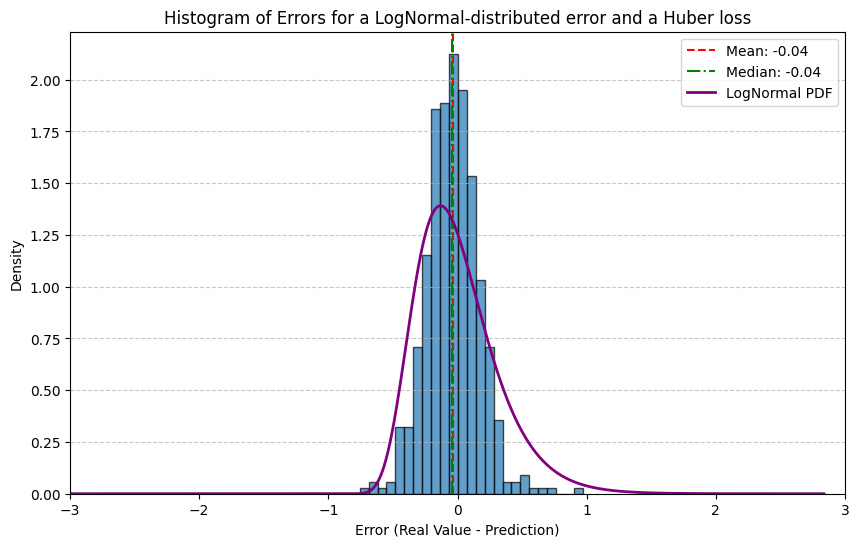

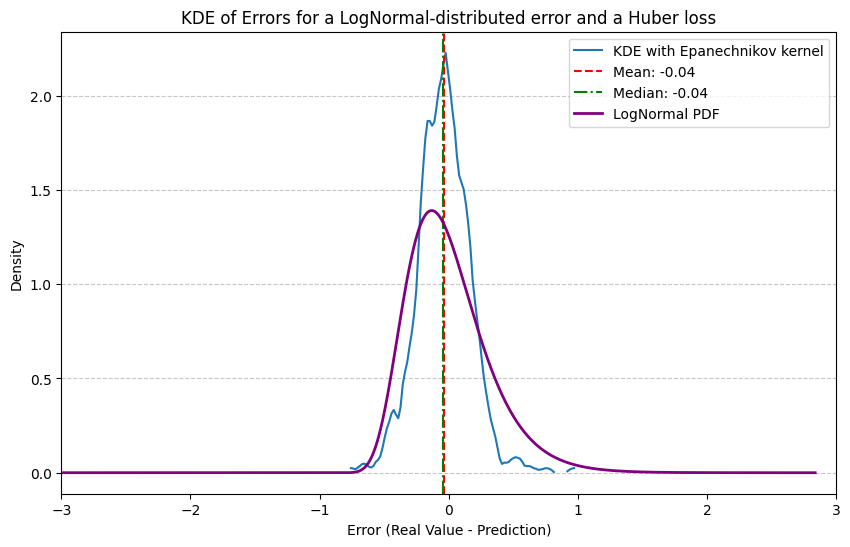

In [21]:
results = {}

for loss, predicted_values in predictions_dict.items():
    print(f"Analyzing errors for {loss} loss...\n")
    
    errors = y_test.flatten() - predicted_values.flatten()
    results[loss] = stats_results(errors,theory)

    plot_hist = RecoveryPlotHist(errors=errors,dist=lognorm)
    plot_hist.get_plot(loss_name=loss,x_limits=[-3,3])

    bw = 1.06 * np.std(errors) * len(errors)**(-1/5)
    plot_kernel = RecoveryPlotKernel(errors=errors,dist=lognorm,kernel="epa",bw=bw)
    plot_kernel.get_plot(loss_name=loss,x_limits=[-3,3])

**Pareto Stochastic Process**

We simulate the time series with a Pareto-distributed error term. In this case, the time series will be a function of the form:

$$f(t)=\sin(0.05t+1)+\varepsilon \quad \text{where} \quad \varepsilon \sim \mathcal{Pa}(1,3)$$

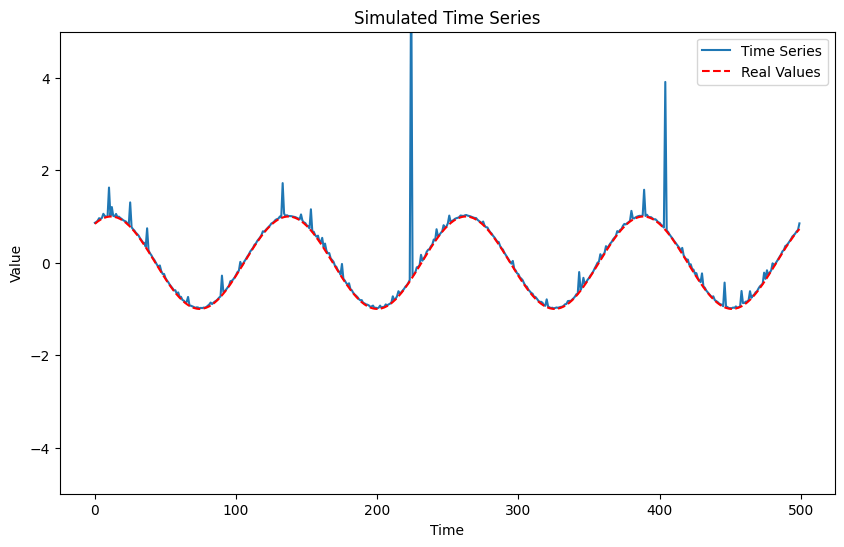

Theoretical Mean: 0.07666666666666672
Theoretical Std. Dev.: None
Theoretical Median: 0.018271121837140185



In [22]:
n = 500
loc = 0
scale = 0.1
params = {"A": 1, "B":0.05, "C":1}
pareto = ParetoDist({"xm": 0.01, "alpha":1.15},demean=False)

simul = TimeSeriesSimulator(determ=sinForm,noise=pareto)
series = simul.simulate(det_params=params, n=500)
simul.plot_sim(scatter_plot=False)

theory = pareto.theory()

print(f"Theoretical Mean: {theory["mean"]}")
print(f"Theoretical Std. Dev.: {theory["std"]}")
print(f"Theoretical Median: {theory["median"]}\n")


Then, we fit a dense neural network to our data. The architecture of this neural network is the follwoing:

- 1 linear input layer with 10 units (sequence length; can be changed)
- 1 ReLU hidden layer with 128 units
- 1 linear output layer with 1 unit
- Batch size of 16
- 50 epochs for training

We use an ADAM optimizer and we try 3 different loss funcions: the L1, the L2 and the Huber losses.

In [23]:
scaler = StandardScaler()
series["Value"] = scaler.fit_transform(series[["Value"]])
seq_length = 10
data = series["Value"].values
series["Determ"] = series["Determ"].iloc[seq_length:].reset_index(drop=True)
x, y = create_sequences_from_ts(data, seq_length)

input_shape = (seq_length,)
x = x.reshape(x.shape[0], seq_length)

# Aprendizaje de la series

vanilla_generator = VanillaNNGenerator()
model = vanilla_generator.generate(input_shape=input_shape,
                                   units={"input": seq_length, "1": 128, "output": 1},
                                   activation={"input": None, "1": "relu", "output": None})

nn_handler = NeuralNetworkHandler(model=model)
loss_functions = {
    "L1": "mae",
    "L2": "mse",
    "Huber": keras.losses.Huber(delta=0.5)  # You can adjust delta as needed
}

results = {}
predictions_dict = {}

for loss_name, loss_fn in loss_functions.items():
    print(f"\nTraining with {loss_name} loss...\n")
    
    # Compile the model with the selected loss function
    nn_handler.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.01),
        loss=loss_fn,
        metrics=["mae","mse","mape"],
        n_batches=1
    )
    
    # Train the model
    nn_handler.train(
        train_x=x,
        train_y=y,
        batch_size=16,
        epochs=50,
        shuffle=True,
        callback=None,
        y_weights=None,
        x_weights=None,
        opt_hyp=False
    )
    
    # Evaluate the model
    loss = nn_handler.evaluate(
        train_x=x,
        train_y=y,
        batch_size=16,
        x_weights=None,
        callbacks=None
    )
    print(f"Evaluation results ({loss_name}): {loss}")
    results[loss_name] = loss

    # Predict with the trained model
    predictions = nn_handler.predict(test_x=x, batch_size=16, callbacks=None)
    predicted_values = np.array(predictions["pred"])

    # Inverse transform the predictions for plotting
    predicted_values = scaler.inverse_transform(predicted_values.reshape(-1, 1))
    predictions_dict[loss_name] = predicted_values

    # Inverse transform the ground truth
    y_test = scaler.inverse_transform(y.reshape(-1, 1))

# Display evaluation results
for loss_name, evaluation_result in results.items():
    print(f"{loss_name} Loss Evaluation: {evaluation_result}")


Training with L1 loss...

Epoch 1/50


c:\Users\Iker\Desktop\Algoritmos_Perrotes\ModellingError_TS\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4163 - mae: 0.4163 - mape: 109.5100 - mse: 0.5070
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1665 - mae: 0.1665 - mape: 55.9805 - mse: 0.2112
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1107 - mae: 0.1107 - mape: 187.2104 - mse: 0.0943
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1483 - mae: 0.1483 - mape: 85.2982 - mse: 0.1943
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1140 - mae: 0.1140 - mape: 45.2154 - mse: 0.0842
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1212 - mae: 0.1212 - mape: 87.3116 - mse: 0.2340
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1105 - mae: 0.1105 - mape: 160.7781 - mse: 0.1051
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1808 - mae: 0.1808 - mape: 198.3333 - mse: 0.7087
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1002 - mae: 0.1002 - mape: 32.0737 - mse: 0.1214
Epoch 10/50
31/31 ━━━━━━━━

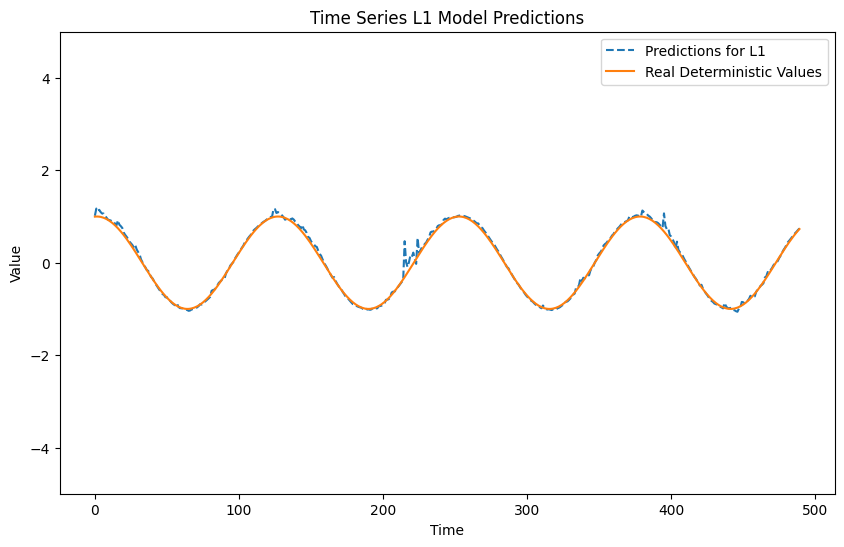

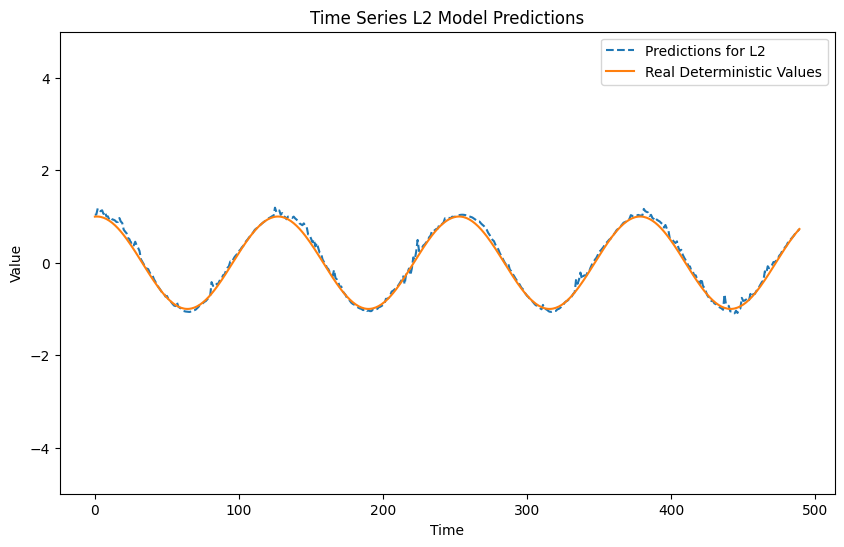

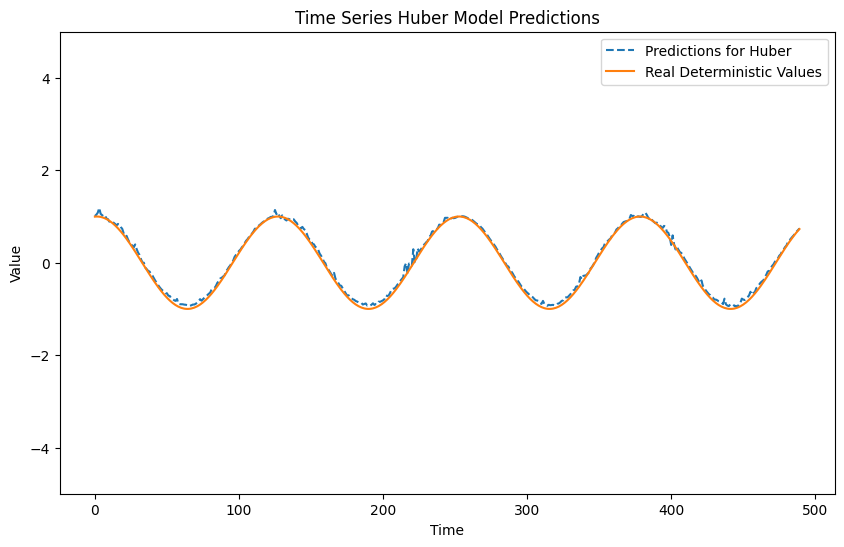

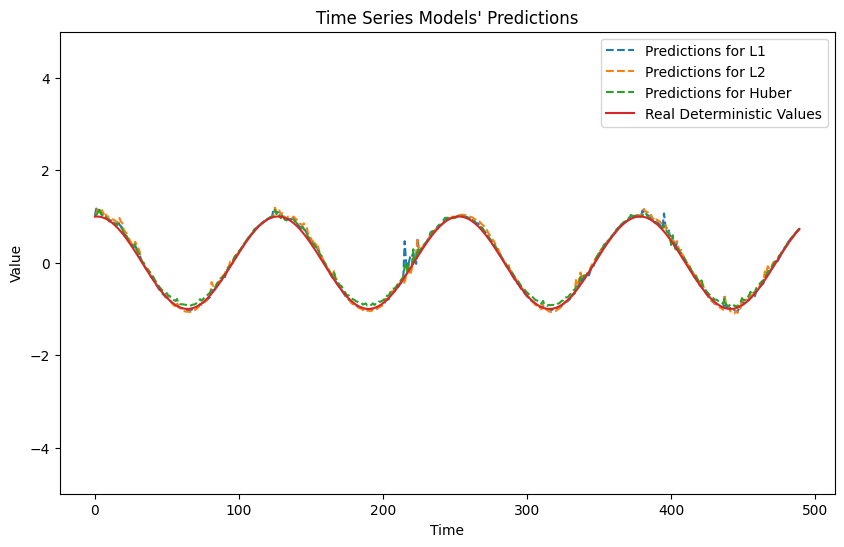

In [24]:
for k in predictions_dict.keys():

    plot_estimations(predictions=predictions_dict[k],series=series,model_name=k,use_total_series=False)

plot_multiple_estimations(pred_dict=predictions_dict,series=series,use_total_series=False)

Finally, we recover the distribution of errors through an histogram and a kernel density estimation:

Analyzing errors for L1 loss...

Mean: 0.03604232859639986 vs. Theoretical Mean: 0.07666666666666672
Median: 0.010366913425166473 vs. Theoretical Median: 0.018271121837140185
Standard Dev.: 0.3586793584931251 vs. Theoretical Std. Dev.: None
Skew: 16.01728586174668
Kurtosis: 291.514081671307
Max: 6.9554281100563
Min: -0.7558006058061865




c:\Users\Iker\Desktop\Algoritmos_Perrotes\ModellingError_TS\src\Probability\classes.py:247: RuntimeWarning: invalid value encountered in power
  pdf_values = np.where(x >= xm, (alpha * xm**alpha) / (x**(alpha + 1)), 0)


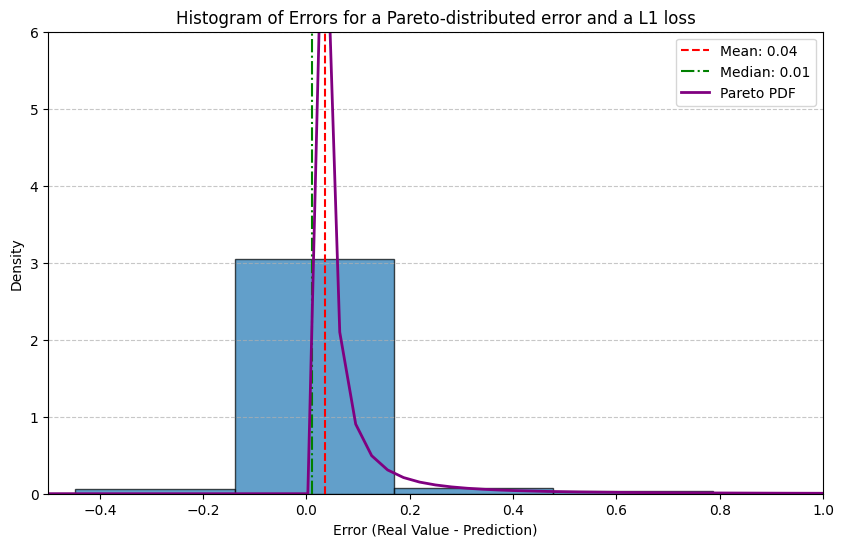

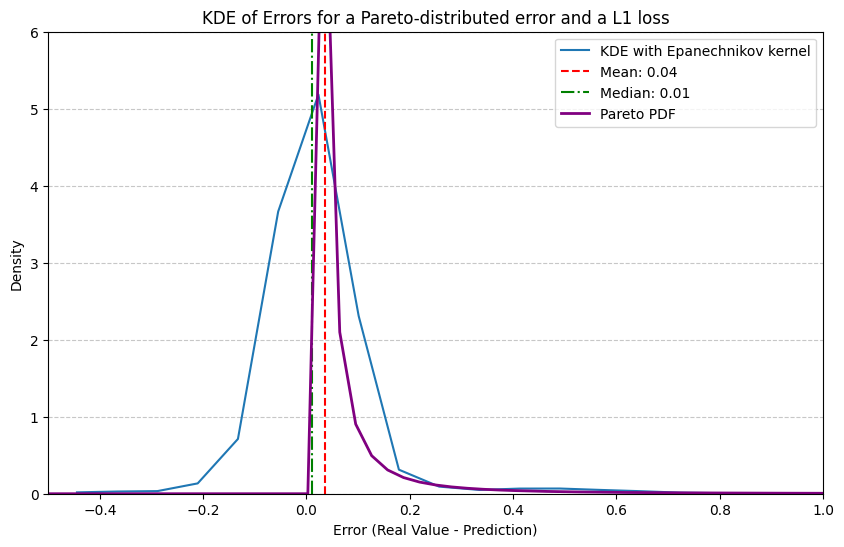

Analyzing errors for L2 loss...

Mean: 0.01894537184125119 vs. Theoretical Mean: 0.07666666666666672
Median: -0.003362284268447726 vs. Theoretical Median: 0.018271121837140185
Standard Dev.: 0.35616662827739465 vs. Theoretical Std. Dev.: None
Skew: 15.965592284165002
Kurtosis: 290.3740227379269
Max: 6.886888281994242
Min: -0.34320709424986184




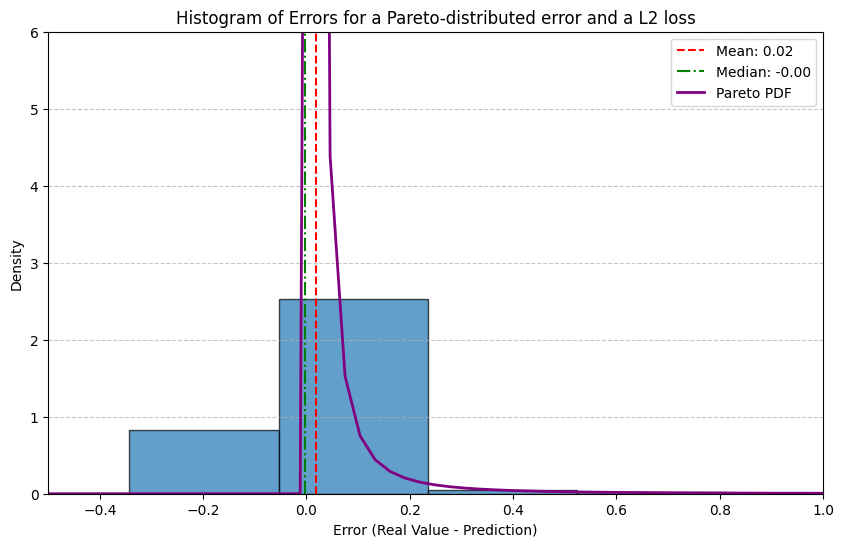

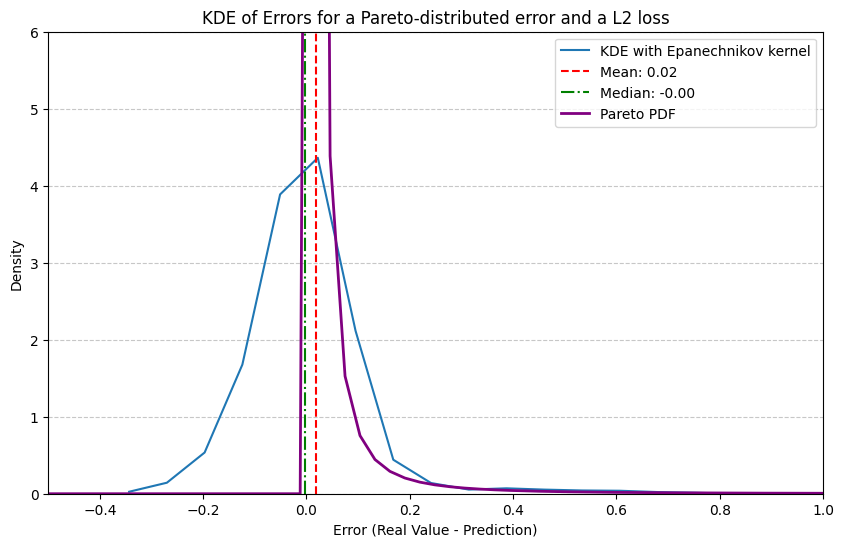

Analyzing errors for Huber loss...

Mean: 0.007395048426758448 vs. Theoretical Mean: 0.07666666666666672
Median: -0.02616045035342192 vs. Theoretical Median: 0.018271121837140185
Standard Dev.: 0.3550036354791937 vs. Theoretical Std. Dev.: None
Skew: 16.47350088277332
Kurtosis: 301.0882639191726
Max: 6.907230035953898
Min: -0.2400896241934216




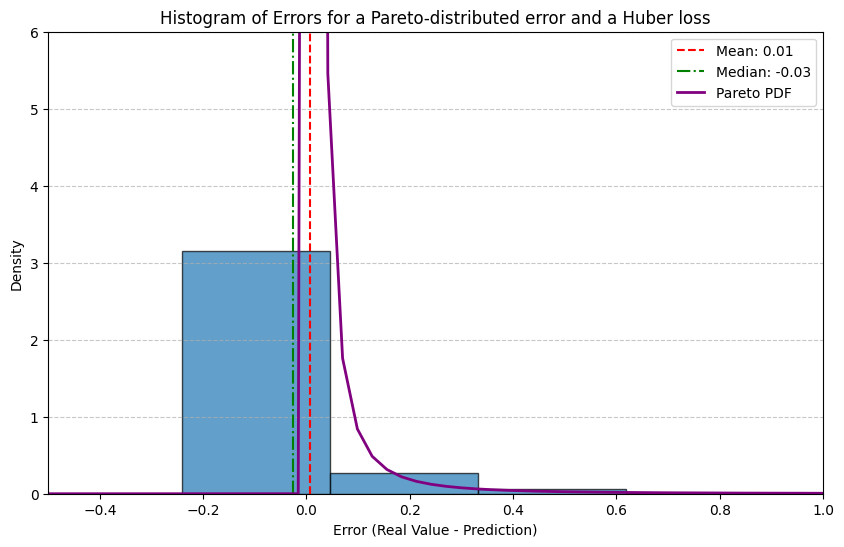

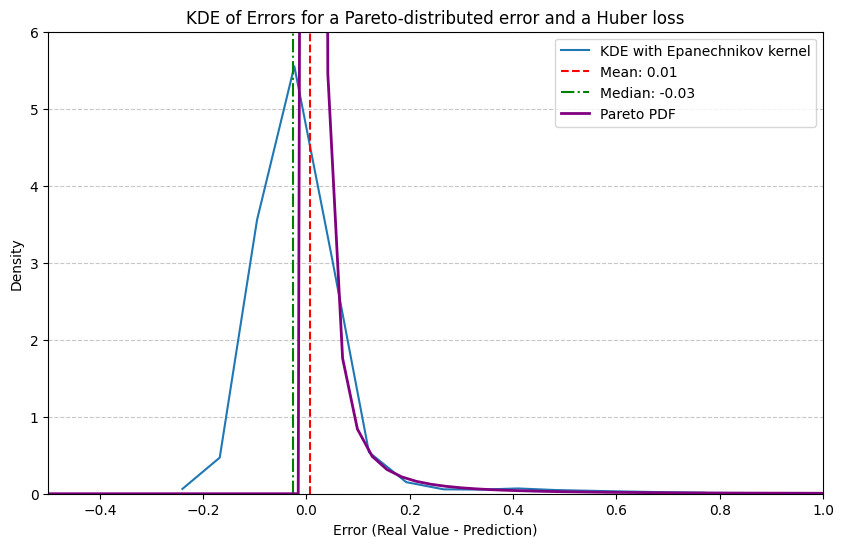

In [25]:
results = {}

for loss, predicted_values in predictions_dict.items():
    print(f"Analyzing errors for {loss} loss...\n")
    
    errors = y_test.flatten() - predicted_values.flatten()
    results[loss] = stats_results(errors,theory)

    plot_hist = RecoveryPlotHist(errors=errors,dist=pareto)
    plot_hist.get_plot(loss_name=loss,x_limits=[-0.5,1],y_limits=[0,6])

    bw = 1.06 * np.std(errors) * len(errors)**(-1/5)
    plot_kernel = RecoveryPlotKernel(errors=errors,dist=pareto,kernel="epa",bw=bw)
    plot_kernel.get_plot(loss_name=loss,x_limits=[-0.5,1],y_limits=[0,6])

To Do:

- $f(t)=t^2+\mu-\mu+X$ ($\mu$ es mediana)
- Graficar función original, función desplazada por la mediana, y ver como se adaptan con L1 y L2
- Probar a generar como $f(t)=g(t)+Y$
- $h(t)-g(t)=mean-\mu \Rightarrow h(t)=t^2+mean$